## TP 1 

### Librerias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.float_format', '{:.10f}'.format)

### Variables

In [4]:
PROB_CROSSOVER = 0.75
PROB_MUTACION = 0.05
CICLOS = 200
CANTIDAD_POBLACION = 10
COEF = 1073741823 # (2^30) - 1
ITERACIONES_IMPRIMIBLES = [20, 100, 200]

### Fitness y Objetivo

In [5]:
def convertirPoblacion(pob_ini, bin=True): # Pasar False para convertir a decimal
    pob_fin = []
    for numero in pob_ini:
        if bin:
            pob_fin.append(format(numero,'030b'))
        else:
            pob_fin.append(int(str(numero), 2))
    return pob_fin

In [6]:
def funcionObjetivo(poblacion_binarios):
    poblacion = convertirPoblacion(poblacion_binarios, False)
    fun_objetivo = []
    for cromosoma in poblacion:
        fun_objetivo.append((cromosoma/COEF)**2)
    return fun_objetivo

In [7]:
def funcionFitness(poblacion_binarios):
    fitness = []
    fun_objetivo = funcionObjetivo(poblacion_binarios)
    for objetivo in fun_objetivo:
        fitness.append((objetivo/sum(fun_objetivo)))
    return fitness

#### Poblacion

In [8]:
def poblacionInicial():
  rng = np.random.default_rng() # Random Number Generator
  poblacion_decimal = rng.integers(low=0, high=COEF, size=CANTIDAD_POBLACION)
  return poblacion_decimal

poblacion_decimal = poblacionInicial()
#poblacion_decimal

#### Binarios

In [9]:
poblacion_binarios = convertirPoblacion(poblacionInicial(), True)
#poblacion_binarios

### Tabla de datos

In [10]:
def generarDataFrame(pob_bin):
    pob_dec = convertirPoblacion(pob_bin, False)
    data = {'Decimales': pob_dec, 'Binarios': pob_bin, 
            'FuncionObjetivo':np.array(funcionObjetivo(pob_bin))}
    data_frame = pd.DataFrame(data)
    data_frame['Fitness'] = np.array(funcionFitness(pob_bin))
    return data_frame
data_frame = generarDataFrame(poblacion_binarios)
#data_frame

#### Estadisticas Marco de datos

In [11]:
def generarEstadisticas(dataFrame):
    indice_cromosoma_max = dataFrame[dataFrame['FuncionObjetivo']==dataFrame['FuncionObjetivo'].max()].index.values[0]
    cromosoma_max = dataFrame['Binarios'][indice_cromosoma_max]
    stats = {'Suma':[ dataFrame['FuncionObjetivo'].sum(), dataFrame['Fitness'].sum() ],
                'Promedio': [ dataFrame['FuncionObjetivo'].mean(), dataFrame['Fitness'].mean() ],
                'Máximo': [ dataFrame['FuncionObjetivo'].max(), dataFrame['Fitness'].max() ], 
                'Mínimo': [ dataFrame['FuncionObjetivo'].min(), dataFrame['Fitness'].min() ]}
    dataFrame_stats = pd.DataFrame(stats, index = ['Función objetivo', 'Fitness'])
    return dataFrame_stats, stats, cromosoma_max
marcoDeDatos_stats, stats, cromosoma_max = generarEstadisticas(data_frame)
#marcoDeDatos_stats

### Ruleta

In [12]:
def ruleta(pob_bin, cantidad_poblacion):
    # Asigna probabilidad basada en el fitness
    cromosomas = np.array(pob_bin)
    probabilidades = np.array(funcionFitness(pob_bin))
    np.random.seed()
    binarios_ruleta = np.random.choice(cromosomas, size=int(cantidad_poblacion), p=probabilidades)
    binarios_ruleta = binarios_ruleta.tolist()
    return binarios_ruleta
binarios_ruleta = ruleta(poblacion_binarios, 10)
#binarios_ruleta

### Crossover

In [21]:
def crossover(poblacion_binarios):
    hijos_crossover = []
    pob_binarios = np.array(poblacion_binarios)
    cantidad_poblacion = len(pob_binarios)
    genes = len(pob_binarios[0])
    for i in range(0, cantidad_poblacion, 2):
        opciones = [True, False]
        np.random.seed()
        # Probabilidades de cada opción
        prob_cross = np.array([PROB_CROSSOVER, (1-PROB_CROSSOVER)])
        cross = np.random.choice(opciones, size=1, p=prob_cross)
        if cross[0]:
            posiciones = [x for x in range(0, genes)]
            probCorte = [(1/genes) for x in range(0, genes)]
            # Devuelve ndarray de 1 elemento
            corte = np.random.choice(posiciones, size=1, p=probCorte)
            posicionCorte = corte[0]
            primerTiraGenesPadre1 = pob_binarios[i][0:posicionCorte]
            segundaTiraGenesPadre1 = pob_binarios[i][posicionCorte:genes]
            primerTiraGenesPadre2 = pob_binarios[i+1][0:posicionCorte]
            segundaTiraGenesPadre2 = pob_binarios[i+1][posicionCorte:genes]
            hijos_crossover.append(primerTiraGenesPadre1 + segundaTiraGenesPadre2)  # Hijo 1
            hijos_crossover.append(primerTiraGenesPadre2 + segundaTiraGenesPadre1)  # Hijo 2
        else:
            hijos_crossover.append(pob_binarios[i])
            hijos_crossover.append(pob_binarios[i+1])
    return hijos_crossover
binarios_crossover = crossover(binarios_ruleta)
#binarios_crossover

### Mutacion

In [14]:
def mutacion(hijos_binarios):
        hijos_mutados = []
        genes = len(str(hijos_binarios[0]))
        for hijo in hijos_binarios:
            opciones = [True, False]
            np.random.seed()
            # Probabilidades de cada opción
            prob_mut = np.array([PROB_MUTACION, (1-PROB_MUTACION)])
            mut = np.random.choice(opciones, size=1, p=prob_mut)
            if mut[0]:
                posiciones = [x for x in range(0, genes)]
                probMutacion = [1/genes for x in range(0, genes)]
                # Devuelve ndarray de 1 elemento
                posicionMutacion = np.random.choice(posiciones, size=1, p=probMutacion)
                posicionMutacion = posicionMutacion[0]
                if hijo[posicionMutacion] == '0':
                    hijo = hijo[:posicionMutacion] + '1' + hijo[posicionMutacion+1:]
                else:
                    hijo = hijo[:posicionMutacion] + '0' + hijo[posicionMutacion+1:]
            hijos_mutados.append(hijo)
        return hijos_mutados
mutados = mutacion(binarios_crossover)
#mutados

### Torneo

In [15]:
def torneo(poblacion_binarios, cantidad_poblacion):
    binarios_torneo = []
    pob_binarios = np.array(poblacion_binarios)
    fitness = np.array(funcionFitness(pob_binarios))
    for i in range(0, cantidad_poblacion):
        posiblesCantidades = [x for x in range(1, (cantidad_poblacion+1))]
        np.random.seed()
        cantidadMiembrosTorneo = np.random.choice(posiblesCantidades, size=1)
        # Trabaja directamente con los fitness de los cromósomas
        miembrosTorneo = np.random.choice(fitness, size=cantidadMiembrosTorneo[0], replace=False)
        ganador = np.amax(miembrosTorneo)
        indiceGanador = np.where(fitness == ganador)  # retorna ndarray
        cromosomaGanador = pob_binarios[indiceGanador[0][0]]
        binarios_torneo.append(cromosomaGanador)
    return binarios_torneo
binarios_torneo = torneo(poblacion_binarios, 10)
binarios_torneo

['111100001110111100101001111010',
 '110010111011100011111110101011',
 '110010111011100011111110101011',
 '111100001110111100101001111010',
 '111100001110111100101001111010',
 '111100001110111100101001111010',
 '111100001110111100101001111010',
 '111100001110111100101001111010',
 '110010111011100011111110101011',
 '111100001110111100101001111010']

### Elitismo

In [16]:
def elitismo(poblacion_binarios, cantidad):
    fitness = funcionFitness(poblacion_binarios)
    elites = []
    for i in range(0, cantidad):
        ganador = max(fitness)
        indiceGanador = fitness.index(ganador)
        cromosomaGanador = poblacion_binarios[indiceGanador]
        elites.append(cromosomaGanador)
        fitness.remove(ganador)
    return elites
elites = elitismo(poblacion_binarios, 2)
elites

['111100001110111100101001111010', '110010111011100011111110101011']

## Iteracion

### Tablas

In [17]:
def hacerTabla(cantIteraciones, cromosomas_maxs, maximos, minimos, promedios):
        iteraciones = [x for x in range(1,cantIteraciones+1)]
        data = {'Iteracion': iteraciones, 'CromosomaMax': cromosomas_maxs, 'Maximo': maximos, 
            'Minimo':minimos, 'Promedio':promedios}
        data_frame = pd.DataFrame(data)
        return data_frame

### Graficos

In [18]:
def hacerGrafico(estadisticas, iteracion):
    estadisticas["Iteración"]=[x for x in range(1,iteracion+1)]
    plt.figure(figsize=(18,18))
    plt.plot(estadisticas["Iteración"], estadisticas["Máximo"], 'b.-', label="Máximo")
    plt.plot(estadisticas["Iteración"], estadisticas["Mínimo"], 'r.-', label="Mínimo")
    plt.plot(estadisticas["Iteración"], estadisticas["Promedio"], 'g.-', label="Promedio")
    plt.legend()
    plt.title("Gráfica iteración: " + str(iteracion))
    plt.xticks(estadisticas["Iteración"][::1])
    plt.yticks(np.arange(0, 1.01, step=0.025))
    plt.xlabel("Iteraciones")
    plt.ylabel("F. Objetivo")
    plt.show()

### Iteracion

CASO A: Método selección ruleta


Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111011010010001100000011010010,0.8580604131,0.0045994342,0.2848357208
2,111011010010001100000011010010,0.8580604131,0.0980697932,0.5182266312
3,111011010010011010100111010101,0.8581633378,0.3039487846,0.6963085039
4,111011010011110110111111111100,0.8588164035,0.3767694727,0.7035910508
5,111011010011110110111111111100,0.8588164035,0.3767694727,0.8000103053
6,111011010011110110111111111100,0.8588164035,0.3767694761,0.7609665939
7,111011010011110110111111111100,0.8588164035,0.3767694761,0.8091563738
8,111011010011110110111111111100,0.8588164035,0.3767694761,0.8102384667
9,111011010111101100100111010101,0.8605538661,0.8580361248,0.8586752687
10,111011010111101100100111010101,0.8605538661,0.8580361248,0.8584821601


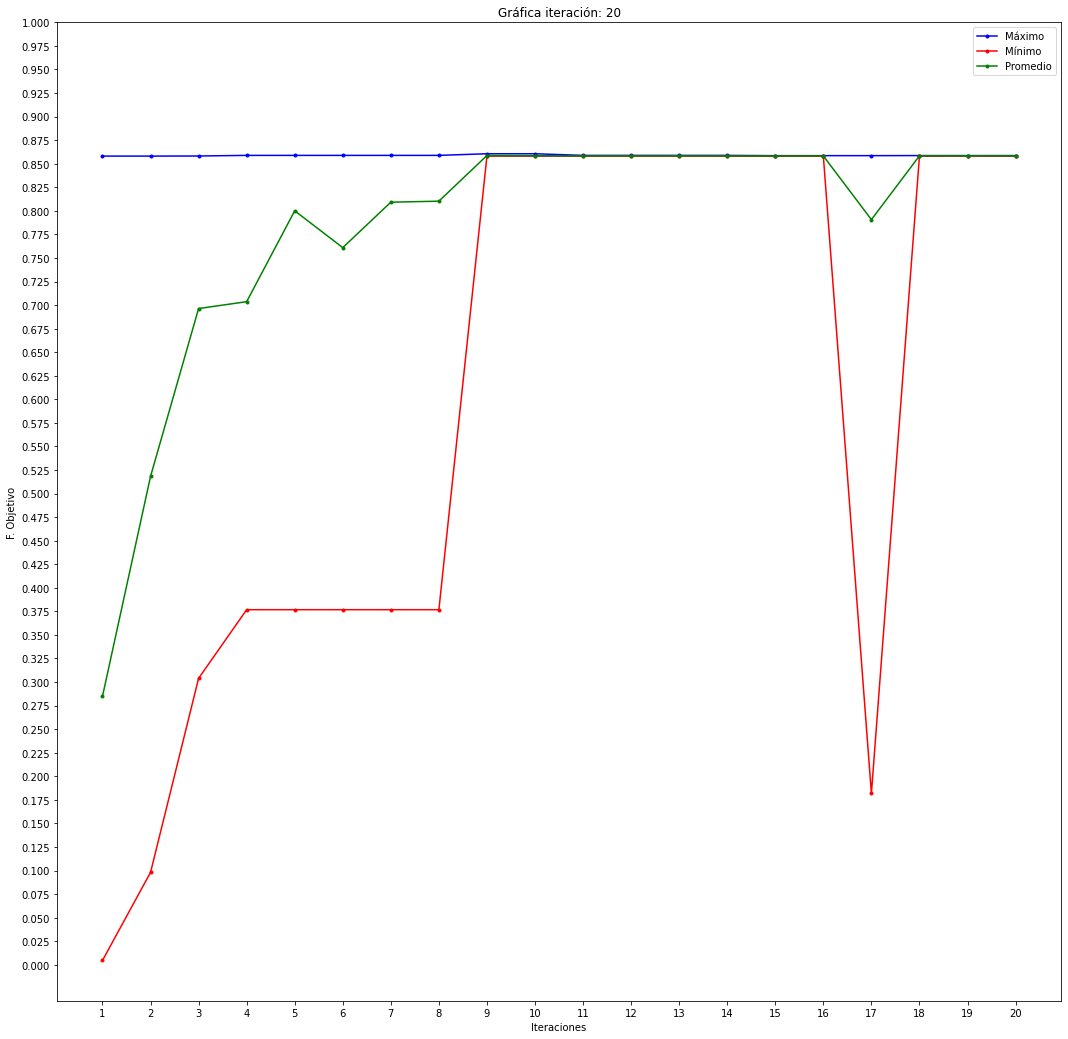

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111101101001101111011011100110,0.9279771417,0.0067633529,0.2802699612
2,111101101001101111011011100111,0.9279771435,0.1157381278,0.4890688673
3,111111110000000010010001111110,0.9922200936,0.2889432877,0.6450189096
4,111111110000000010010001111110,0.9922200936,0.5088192904,0.6268942327
5,111111110000000101101100111011,0.9922460933,0.5088192904,0.7047202205
6,111111110000000101101100111010,0.9922460914,0.5088531663,0.7306121505
7,111101101111110010010001111110,0.9308224767,0.5109112283,0.8457158852
8,111101101111110011011011100111,0.9308309463,0.9129863690,0.9279145593
9,111101101111110010011100111010,0.9308237346,0.9279686798,0.9291320196
10,111101101111110101101100111110,0.9308476645,0.9279686869,0.9288522266


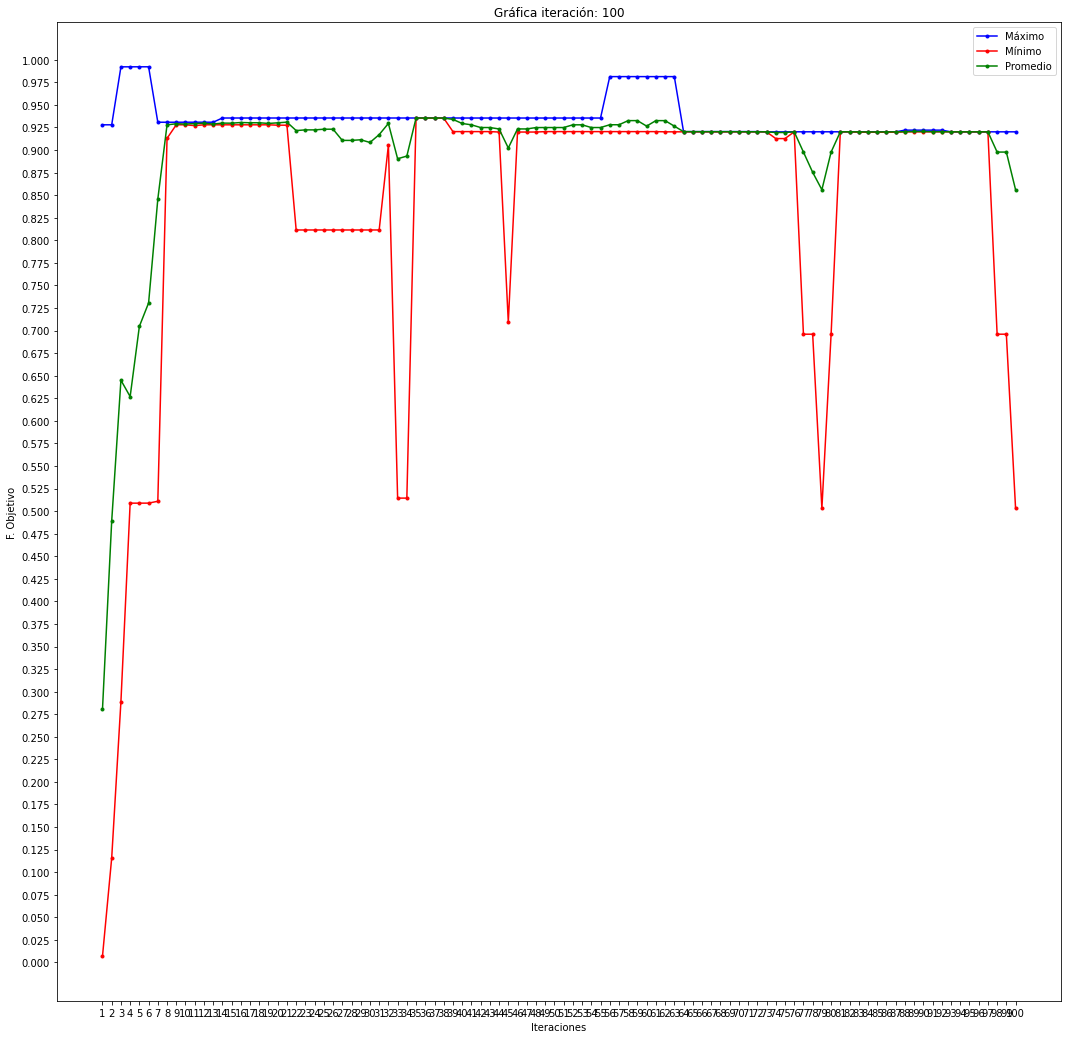

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,110000111110001010000111000000,0.5854932147,0.0042521485,0.1639368563
2,110000111110101101100001101001,0.5856999869,0.0740392158,0.4264582488
3,110000111110001010000111001001,0.5854932276,0.2000810381,0.5329708692
4,110000111110001010000111001001,0.5854932276,0.5819690674,0.5847883880
5,110000111110001011000111000000,0.5854990526,0.5819690788,0.5851413513
6,110000111110001101100001101000,0.5855131570,0.5819492098,0.5851407735
7,110000111110001101100001100000,0.5855131456,0.5819491970,0.5844319736
8,110000111110001010000111001001,0.5854932276,0.5819491970,0.5844298371
9,110000111110001010000111001001,0.5854932276,0.5819488460,0.5841872100
10,110000111110001010000111001001,0.5854932276,0.5819488460,0.5848402714


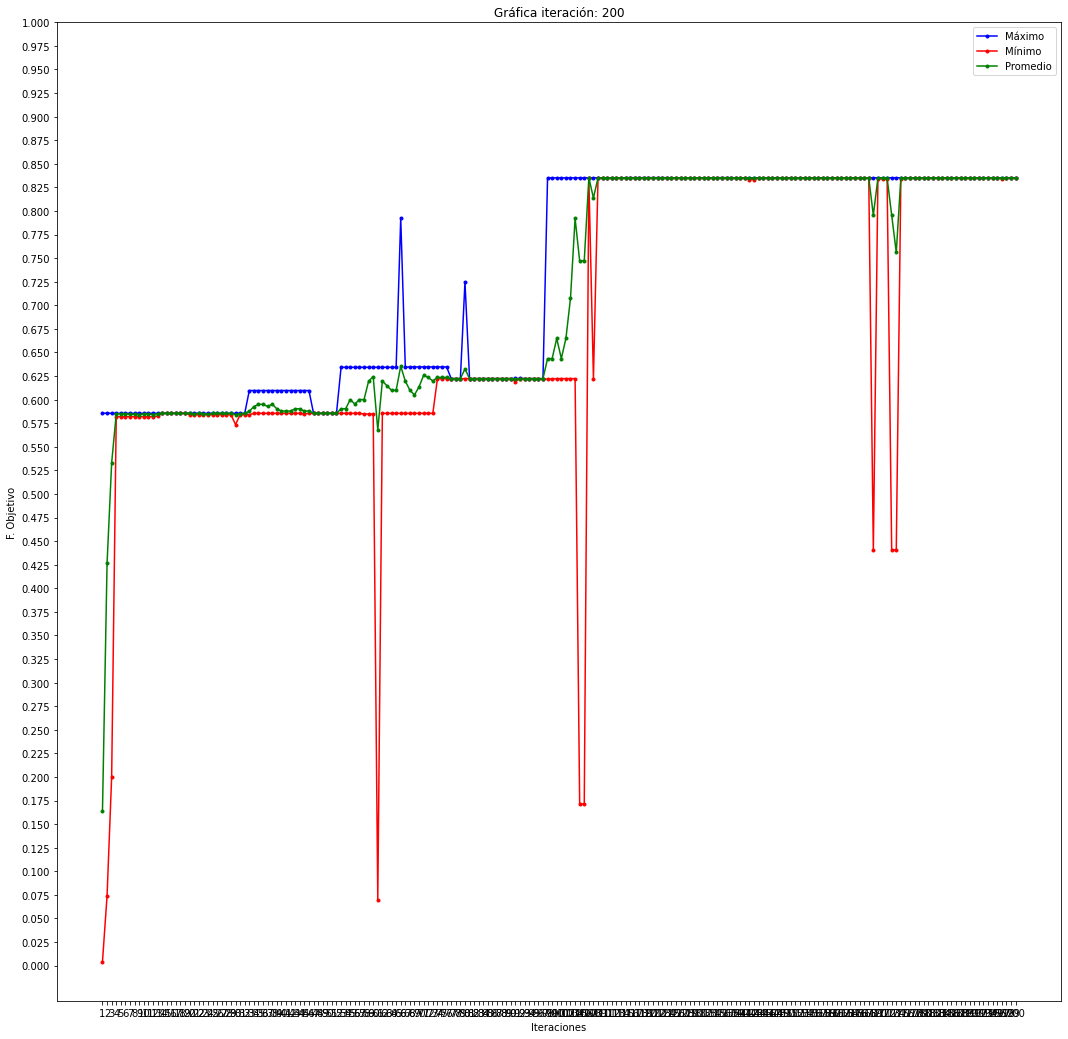

CASO B: Método selección torneo


Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,101111000110010110111001100000,0.5415888364,0.0041755706,0.2231084613
2,101111000110010110111001100000,0.5415888364,0.5121826365,0.5357075964
3,101111000110010110111001100000,0.5415888364,0.5415888364,0.5415888364
4,101111000110010110111001100000,0.5415888364,0.5415888364,0.5415888364
5,101111000110010110111001100000,0.5415888364,0.5415888364,0.5415888364
6,101111000110010110111001100000,0.5415888364,0.5415888364,0.5415888364
7,101111000110010110111001100000,0.5415888364,0.5415888364,0.5415888364
8,101111000110010110111001100000,0.5415888364,0.5415888364,0.5415888364
9,101111000110010110111001100000,0.5415888364,0.5415888364,0.5415888364
10,101111000110010110111001100000,0.5415888364,0.5415888364,0.5415888364


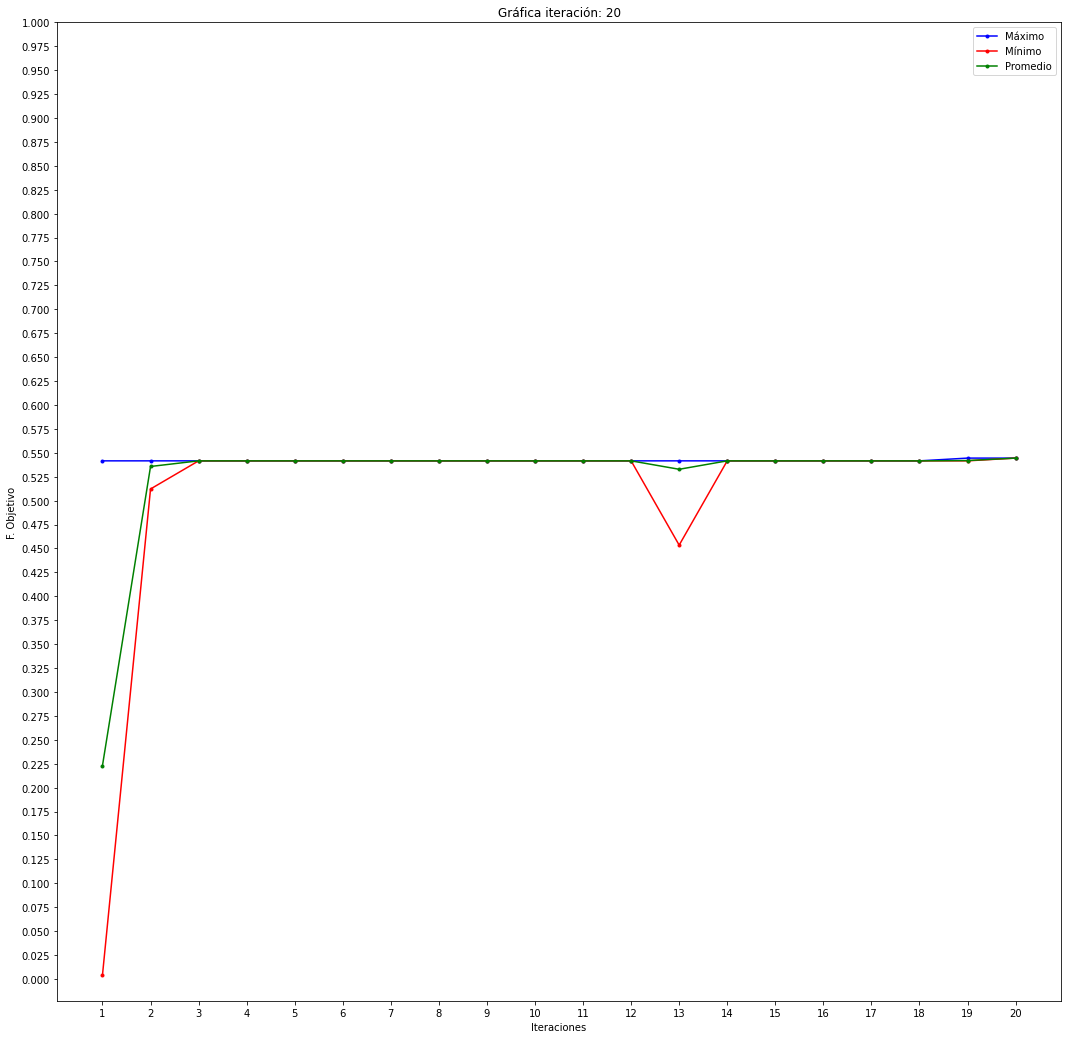

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111100111000000100110100000011,0.9047628668,0.0004325221,0.4569870672
2,111100111000000100110100000011,0.9047628668,0.7498703822,0.8711870351
3,111100111000000100110100000011,0.9047628668,0.2035726295,0.8346438427
4,111100111000000100110100000011,0.9047628668,0.9047628668,0.9047628668
5,111100111000100100110100000011,0.9049951059,0.9047628668,0.9047860907
6,111100111000100100110100000011,0.9049951059,0.9047628668,0.9049486581
7,111100111000100100110100000011,0.9049951059,0.9049951059,0.9049951059
8,111100111000100100110100000011,0.9049951059,0.9049951059,0.9049951059
9,111100111000110100110100000011,0.9051112366,0.9049951059,0.9050067189
10,111100111000110100110100001011,0.9051112508,0.9049951059,0.9050647857


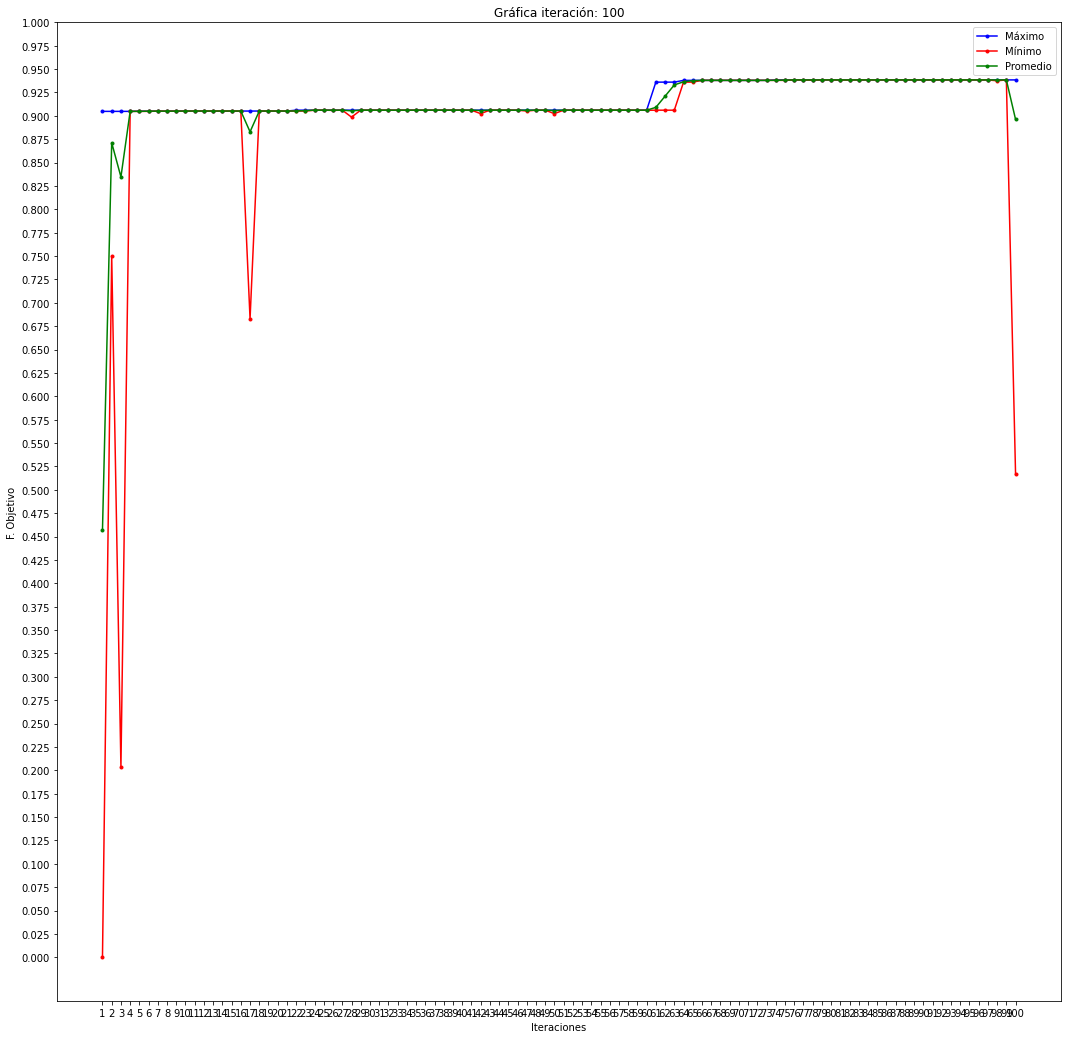

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,101100110010001101000100001110,0.4896596833,0.0006156224,0.1523392625
2,110111000100001100111101100111,0.7402899012,0.0030999029,0.3330795119
3,110111000100001101000100011101,0.7402906032,0.4896591320,0.6901638854
4,110111000100001101000100011101,0.7402906032,0.4896591320,0.7152273835
5,110111000100001101000100011101,0.7402906032,0.4896591320,0.7152274561
6,110111000100001101000100011101,0.7402906032,0.7402905904,0.7402906019
7,110111000100001101000100011101,0.7402906032,0.7402906032,0.7402906032
8,110111000100001101000100011101,0.7402906032,0.7402906032,0.7402906032
9,110111000100001101000100011101,0.7402906032,0.7402906032,0.7402906032
10,110111000100001101000100011101,0.7402906032,0.7402906032,0.7402906032


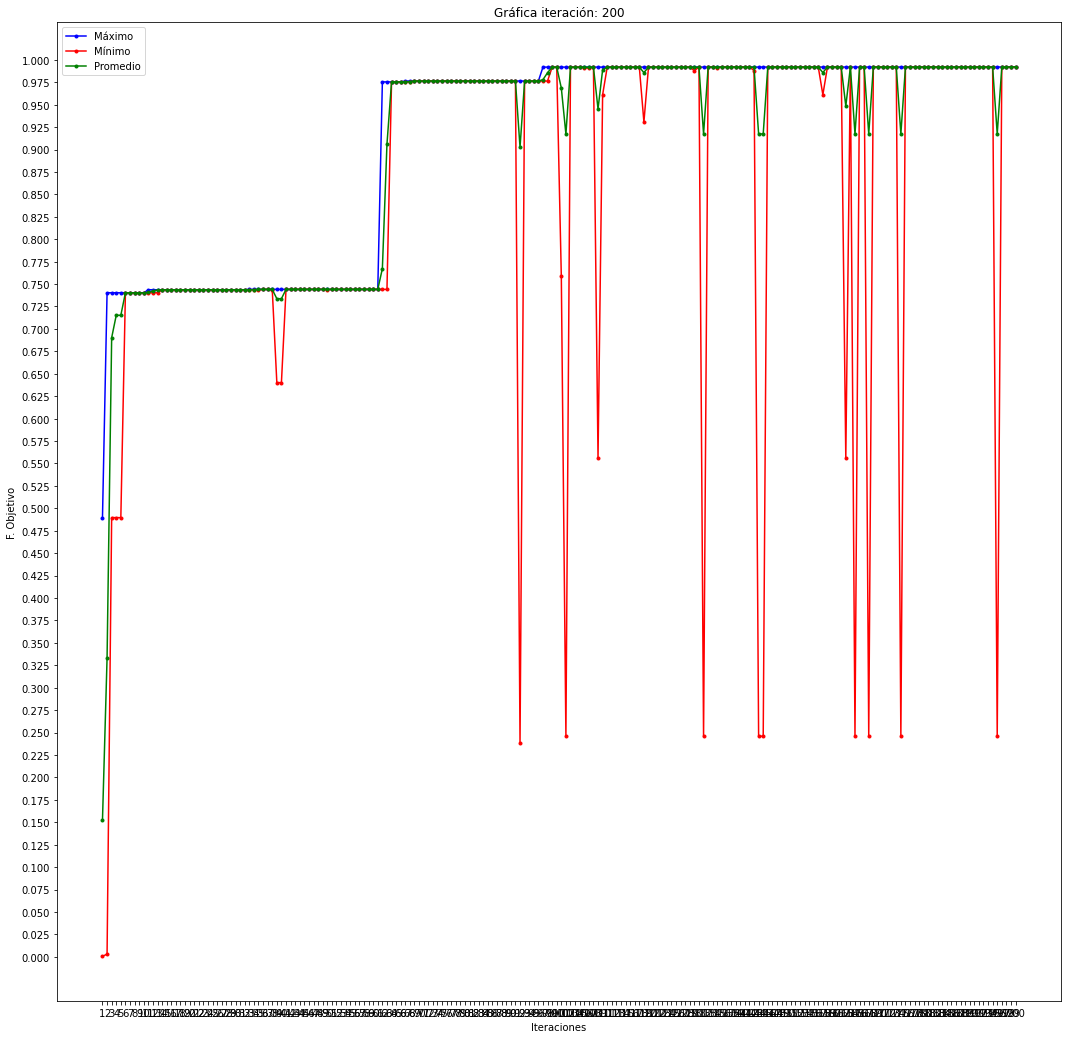

CASO C: Método selección Ruleta con elitismo


Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,110111010000100111010100000101,0.7455134730,0.0850973174,0.3413590123
2,110111110000101011010010000000,0.7590919936,0.2244352234,0.6080217543
3,110111110000101011010010000000,0.7590919936,0.2462728524,0.6626439582
4,110111110000101011010010000000,0.7590919936,0.5739520927,0.7310781513
5,110111110000101011010010000001,0.7590919952,0.5739520913,0.7310730391
6,110111110000101011010010000001,0.7590919952,0.7455134730,0.7529788035
7,110111110000101011010010000101,0.7590920017,0.7455134649,0.7543366557
8,110111110000101011010010000101,0.7590920017,0.7455134665,0.7543366573
9,110111110000101011010100000101,0.7590922094,0.7455132607,0.7563758562
10,110111110000101011010100000101,0.7590922094,0.7455132607,0.7563758983


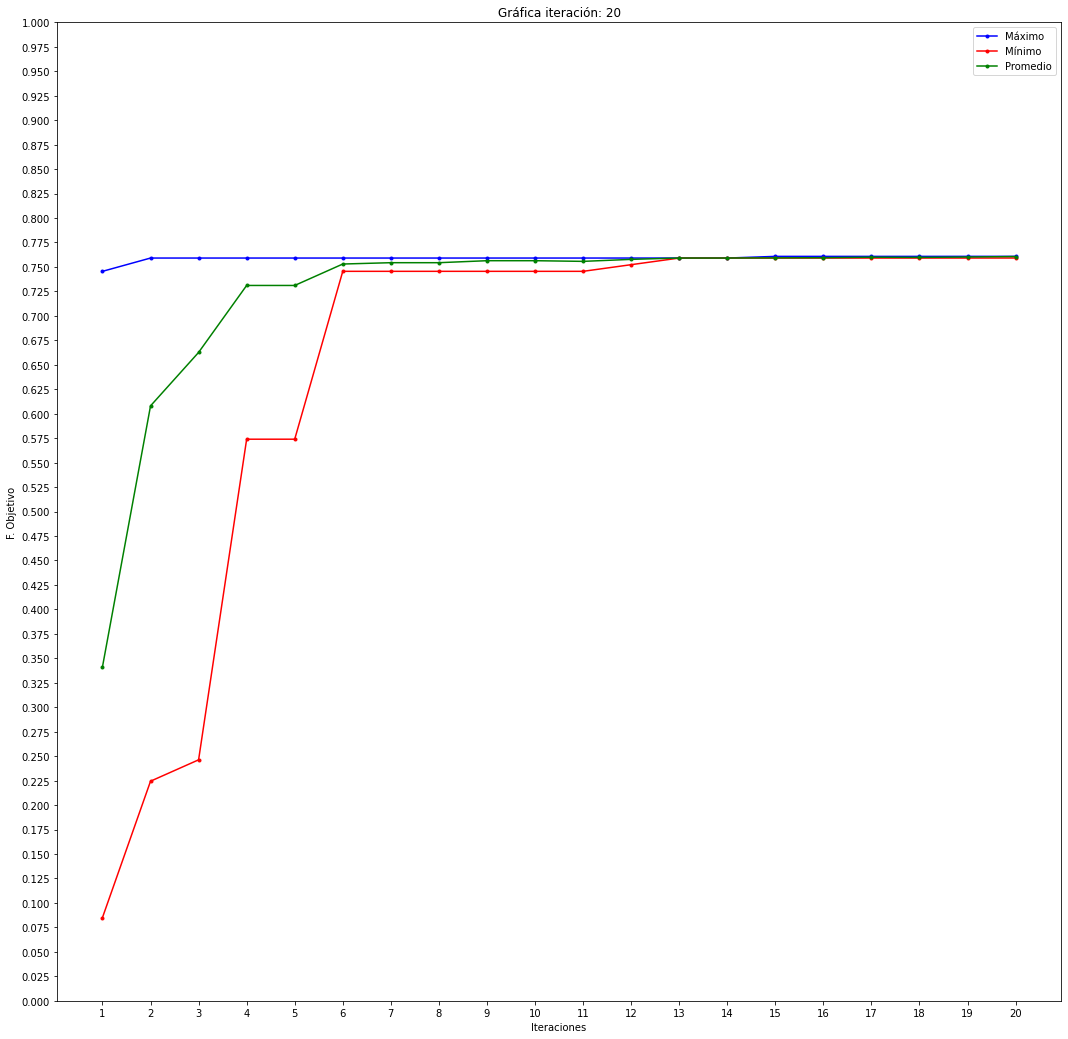

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111111110110010111011100001111,0.9953015631,0.0385838645,0.2688908470
2,111111110110010111011100001111,0.9953015631,0.2566274909,0.7341782814
3,111111110110010111011100001111,0.9953015631,0.2566274890,0.7188883938
4,111111110110111101111111100000,0.9955950139,0.2564785136,0.8454892650
5,111111110110111101111111100010,0.9955950176,0.9953015352,0.9953895935
6,111111110110111101111111100010,0.9955950176,0.9953015389,0.9954776319
7,111111110110111101111111100010,0.9955950176,0.9953015631,0.9955069792
8,111111110110111101111111100010,0.9955950176,0.9953015631,0.9954826218
9,111111110110111111011111100000,0.9956064328,0.9953015631,0.9954890438
10,111111110110111111011111100000,0.9956064328,0.9953015631,0.9954825727


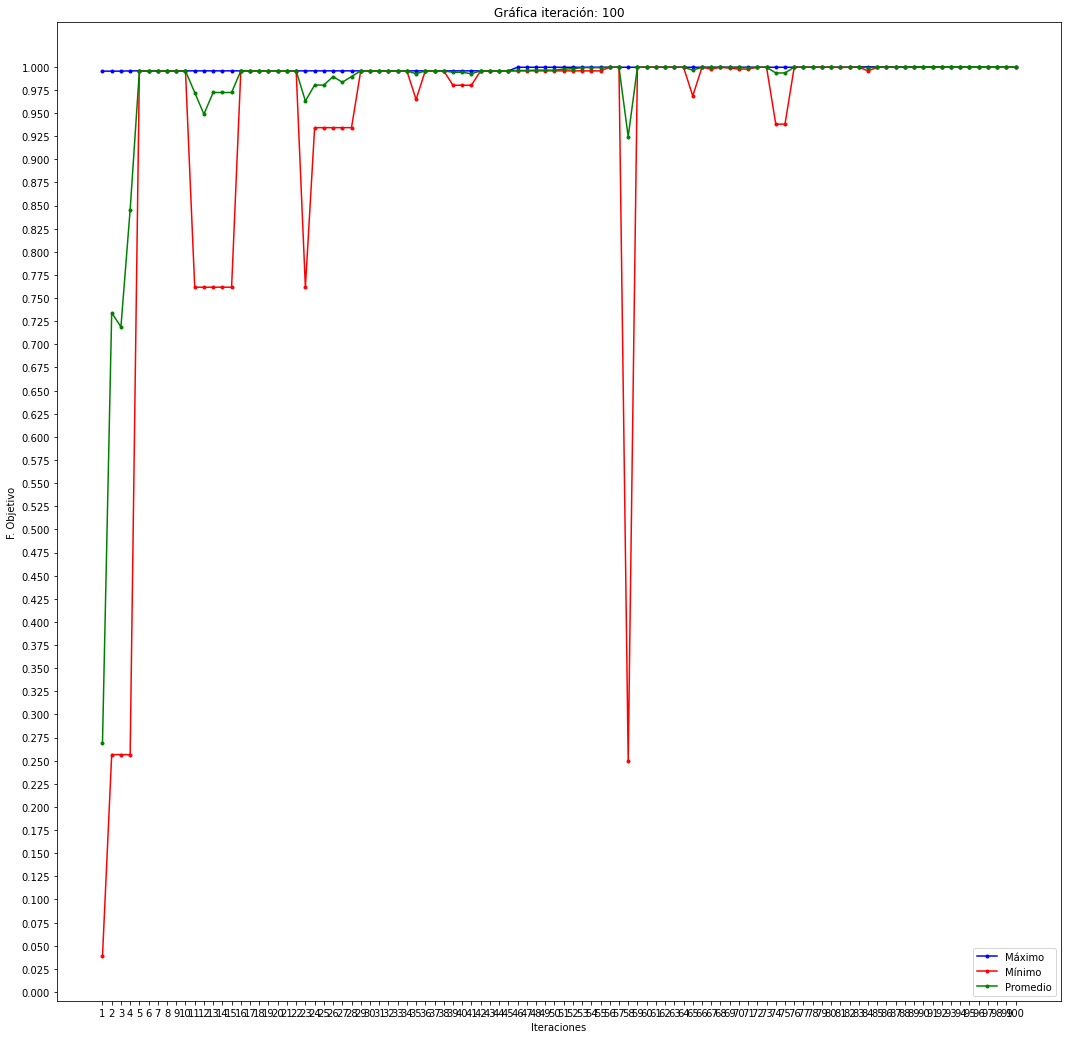

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,110101011001100011001110011000,0.6961614282,0.0077679924,0.3634376535
2,110101011001100011001110011000,0.6961614282,0.2682220324,0.4764251965
3,110101011001100011001110011000,0.6961614282,0.2682301396,0.5479675326
4,110101011001100011001110011000,0.6961614282,0.2682301396,0.6450378068
5,110101110001101111000001101101,0.7060491080,0.6449903102,0.6878678343
6,110101110001101111001110011000,0.7060503774,0.3125011676,0.6556445952
7,110101110001101111001110011000,0.7060503774,0.5957723172,0.6910663589
8,110101110001101111001110101101,0.7060504102,0.6961601679,0.7011055104
9,110101110001101111001110101101,0.7060504102,0.6961601679,0.7030831857
10,110101110001101111001110101101,0.7060504102,0.7060490752,0.7060498795


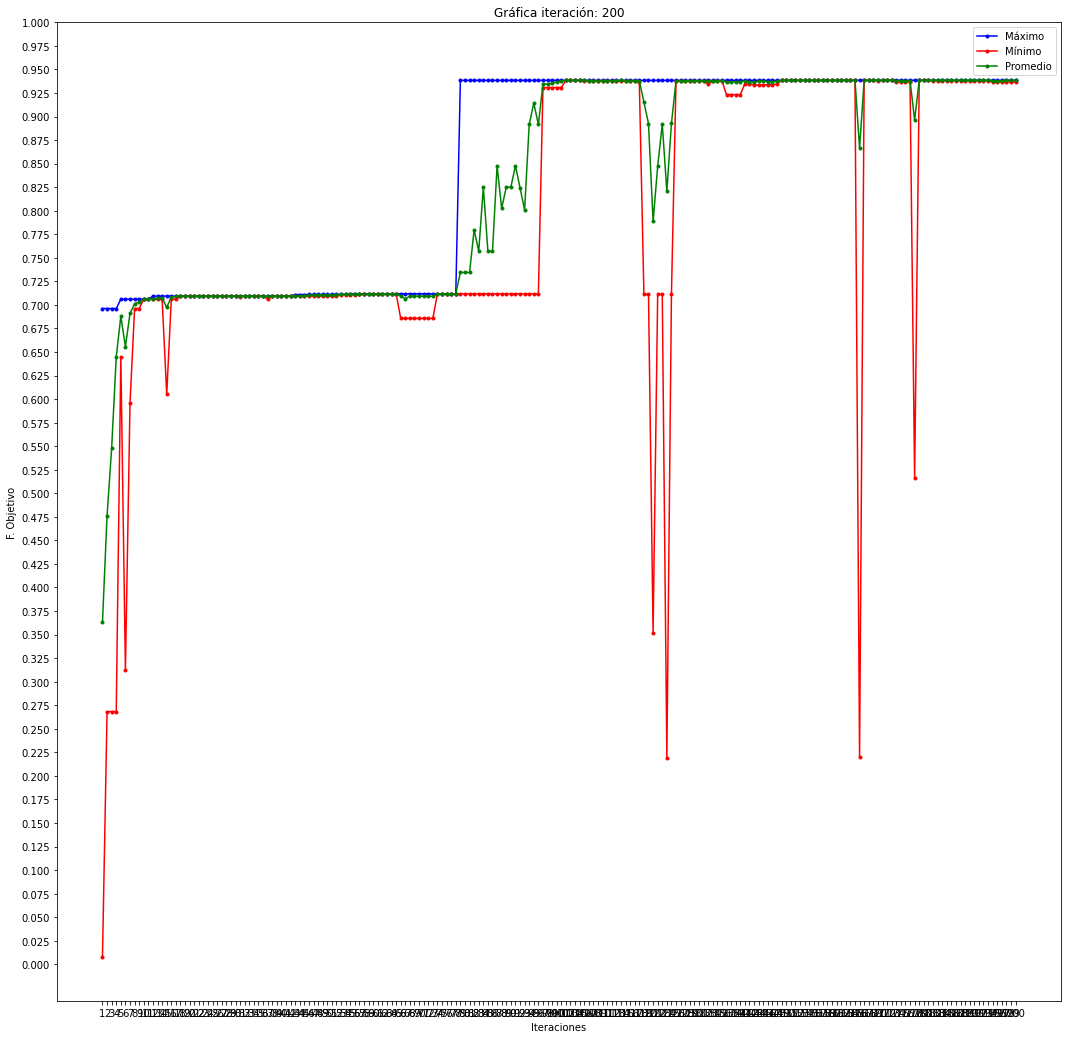

CASO C: Método selección torneo con elitismo


Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,101010110010100010011000101110,0.4470101878,0.0021196773,0.1692241825
2,101010110010100010011000101110,0.4470101878,0.0364249251,0.3264124709
3,101010110010100010011000101110,0.4470101878,0.4470101691,0.4470101859
4,101010110010100010011000101110,0.4470101878,0.4470101878,0.4470101878
5,101010110010100010011000101110,0.4470101878,0.4470101878,0.4470101878
6,101010110010100010011000101110,0.4470101878,0.4470101878,0.4470101878
7,101010110010100010011000101110,0.4470101878,0.4470101878,0.4470101878
8,101010110010100010011001101110,0.4470102675,0.4470101878,0.4470101957
9,101010110010100010011001101110,0.4470102675,0.4470101878,0.4470102436
10,101010110010100010111001101110,0.4470128179,0.4470101878,0.4470105165


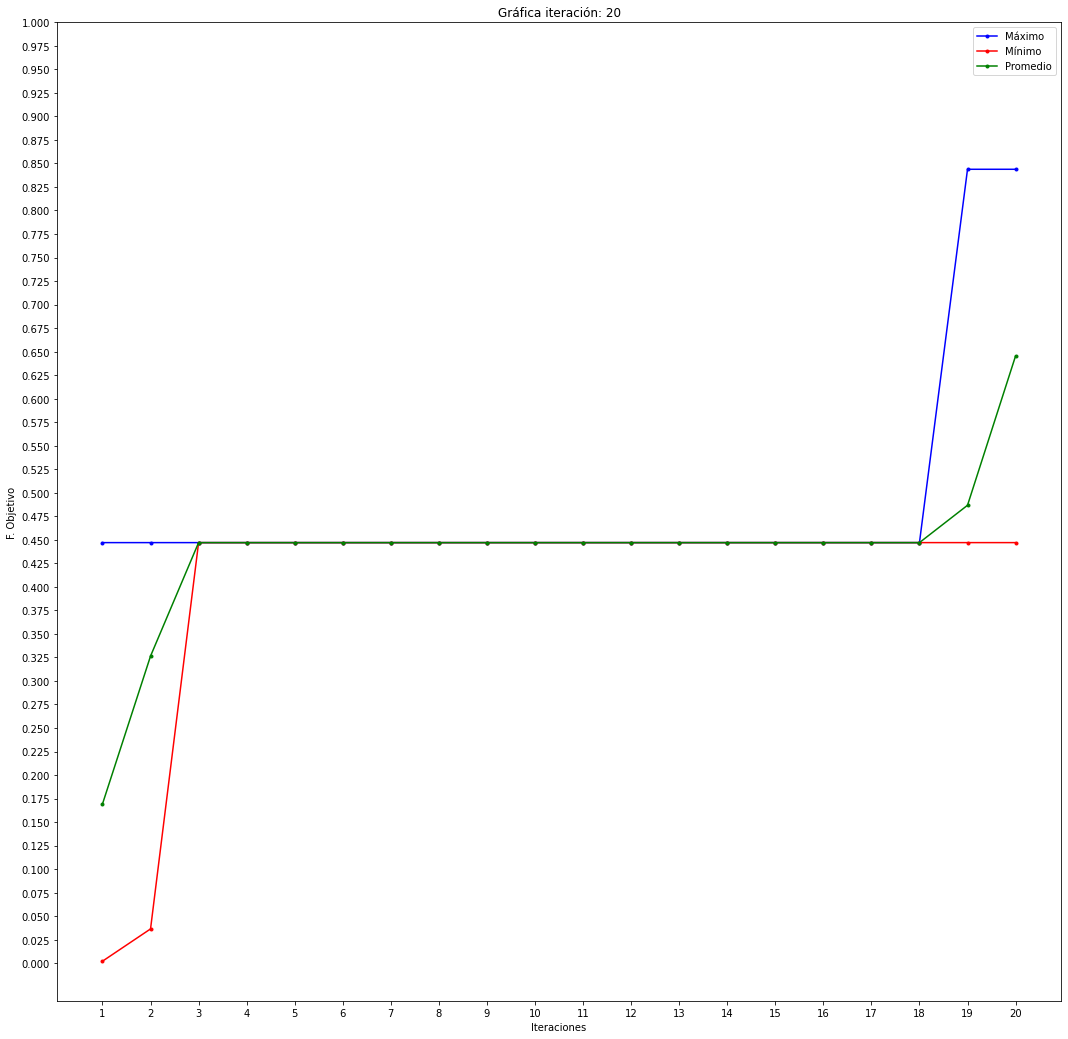

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111111001101111101110110101001,0.9757187764,0.0111238425,0.4957421233
2,111111111000111011011011011101,0.9965501393,0.2379339935,0.8177148866
3,111111111101111101110110101001,0.9990073113,0.2379339935,0.9101276273
4,111111111101111101111011011101,0.9990078847,0.2379339935,0.8764490178
5,111111111101111101111011011101,0.9990078847,0.2495040650,0.8783431382
6,111111111101111101111011011101,0.9990078847,0.9990078847,0.9990078847
7,111111111101111101111011011101,0.9990078847,0.2495040650,0.9240575028
8,111111111101111101111011011101,0.9990078847,0.9990078847,0.9990078847
9,111111111101111101111011011101,0.9990078847,0.9990078847,0.9990078847
10,111111111101111101111011011101,0.9990078847,0.9990078847,0.9990078847


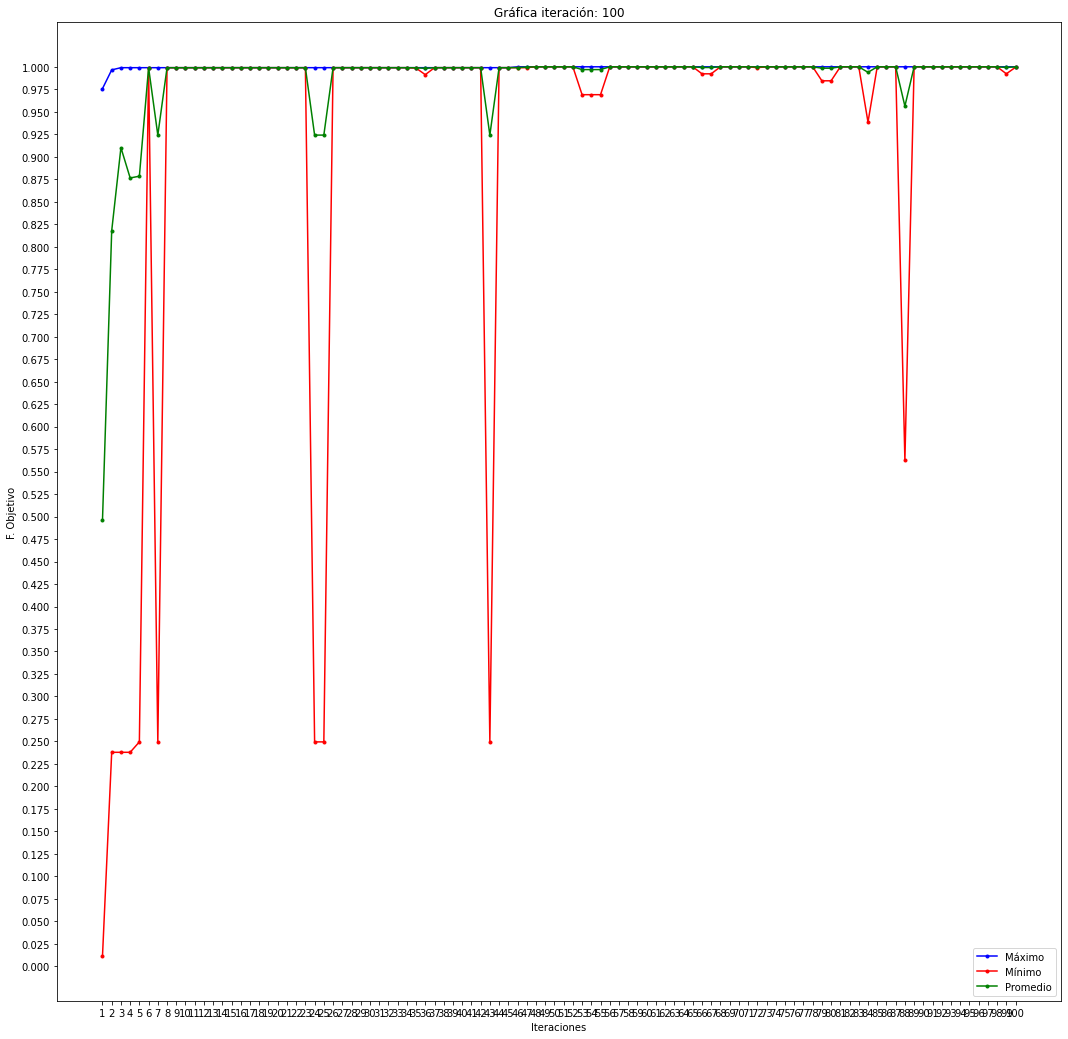

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111111101101110111001111010011,0.9911637051,0.0258971698,0.3222528632
2,111111101101110111001111010011,0.9911637051,0.1267995291,0.6772303929
3,111111101101110111011111001010,0.9911655873,0.7578956926,0.9678236083
4,111111101101110111011111001010,0.9911655873,0.9911124205,0.9911597058
5,111111101101110111011111001010,0.9911655873,0.9602980718,0.9880784593
6,111111101101110111011111001010,0.9911655873,0.9911655873,0.9911655873
7,111111101101110111011111001010,0.9911655873,0.9911655873,0.9911655873
8,111111101101110111011111001010,0.9911655873,0.9911655873,0.9911655873
9,111111101101110111011111001010,0.9911655873,0.9911655873,0.9911655873
10,111111101101110111011111101010,0.9911656466,0.9911655873,0.9911655932


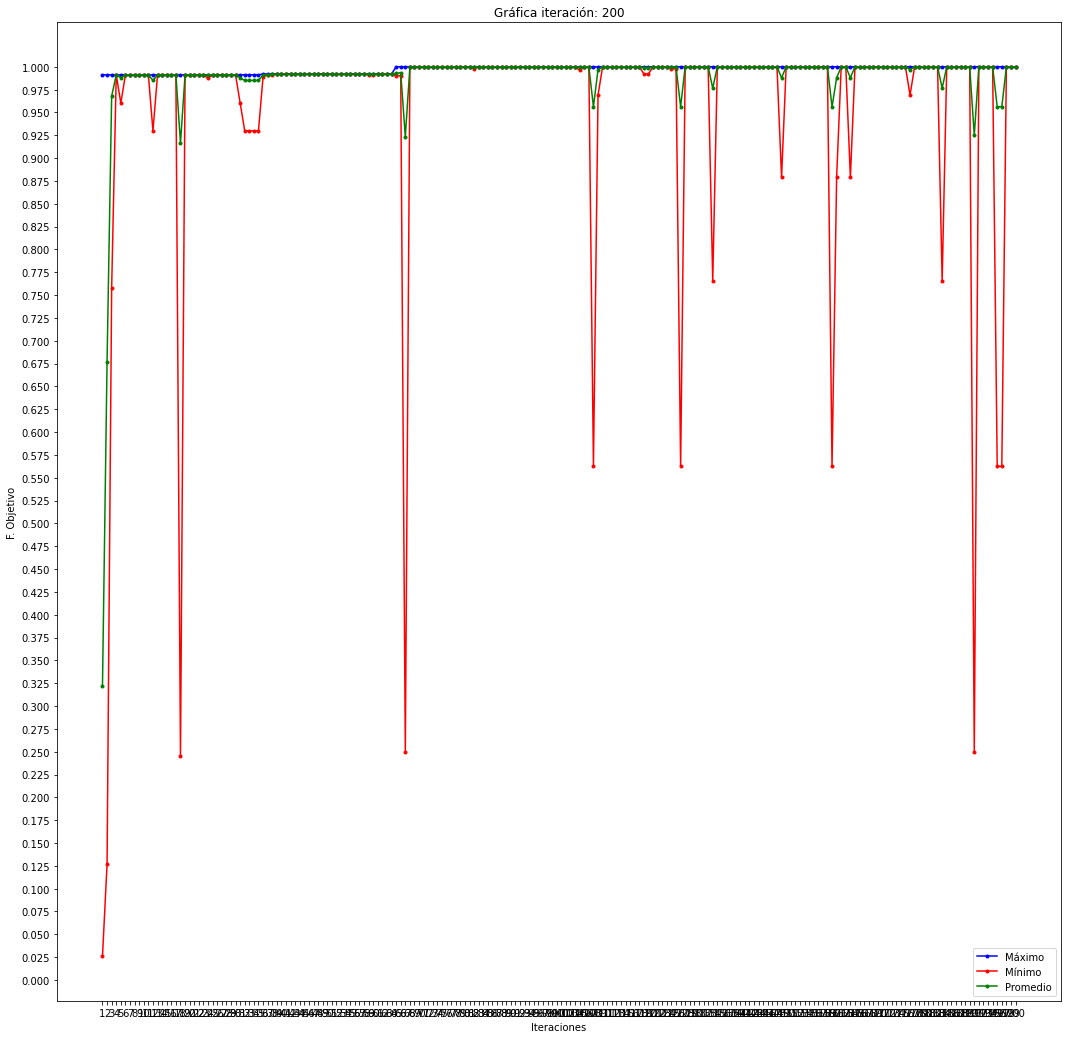

CASO A: Método selección ruleta sin mutacion


Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111110010110001100100111001101,0.9490056453,0.0021569521,0.5032680117
2,111110010110001100100111001101,0.9490056453,0.7194858105,0.8687886998
3,111110001001111001000111100111,0.9431617638,0.7194858105,0.8988793128
4,111110001001111001001101110001,0.9431624765,0.7198450205,0.9015025273
5,111110010111001100100111001101,0.9494813734,0.8981884089,0.9252694959
6,111110001111000101010101101010,0.9456249176,0.9306298683,0.9321299016
7,111110001111000100000111001101,0.9456158231,0.9306298683,0.9321298943
8,111110101111011000000111001101,0.9610206213,0.9154715950,0.9321545468
9,111110101111011000000111001101,0.9610206213,0.9306306230,0.9336721031
10,111101101111011001010101101010,0.9306388905,0.9306306230,0.9306331033


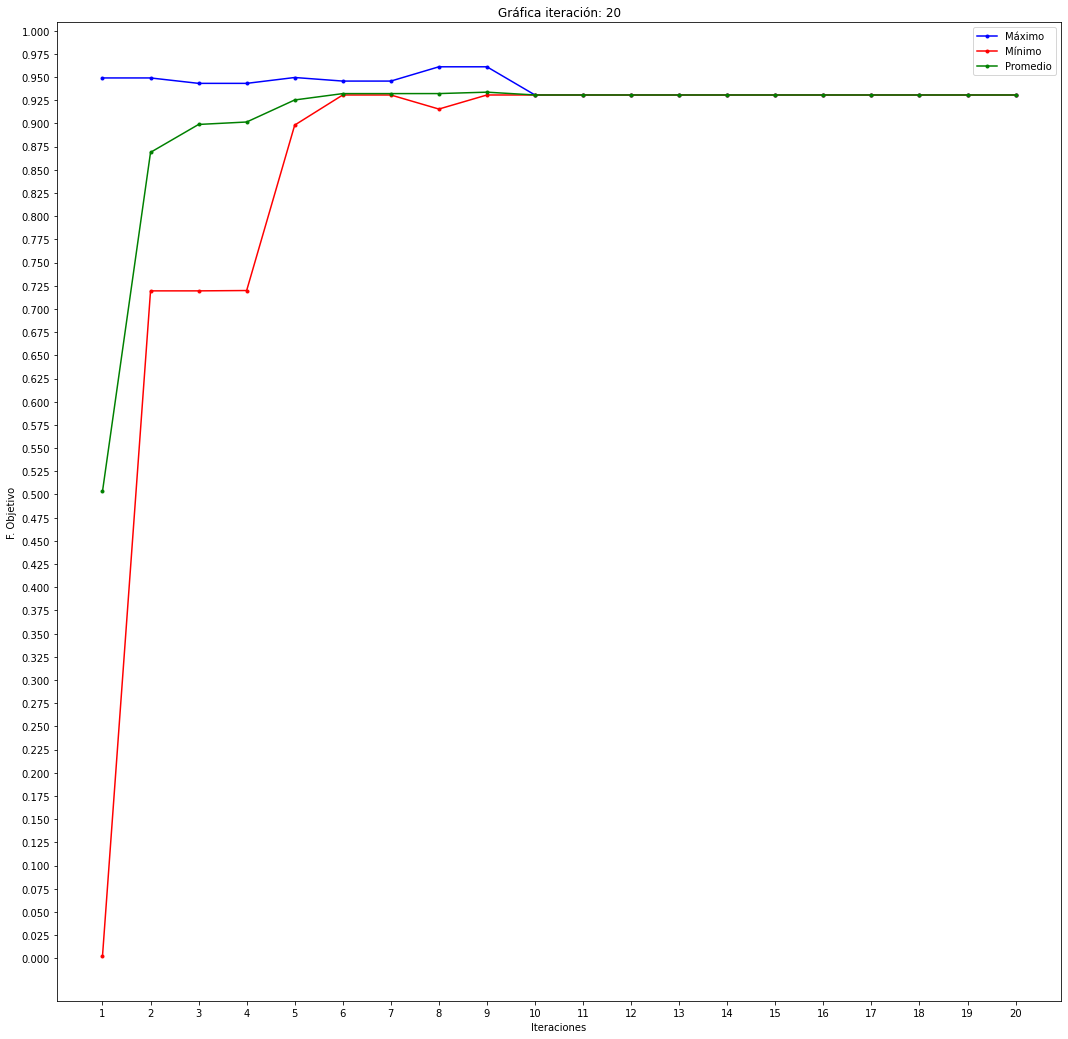

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111010101101111111011011000100,0.8417663722,0.0010404334,0.3394203224
2,111010101101111111010010101110,0.8417654596,0.0991038237,0.4549678211
3,111010101101110010011101100011,0.8416756489,0.1057209419,0.4708278359
4,111010110010001010101100001100,0.8436382322,0.4545221757,0.6396236424
5,111010110010001010101100001100,0.8436382322,0.4665625275,0.7671423841
6,111010110010001010101100001111,0.8436382374,0.8372924566,0.8411457247
7,111010110010001010101100001111,0.8436382374,0.8372924515,0.8396803113
8,111010101111111111011101100011,0.8426628573,0.8363083999,0.8394843131
9,111010101111111010011011000011,0.8426275665,0.8363083999,0.8402624622
10,111010101101110111011101100011,0.8417106464,0.8363083999,0.8396305180


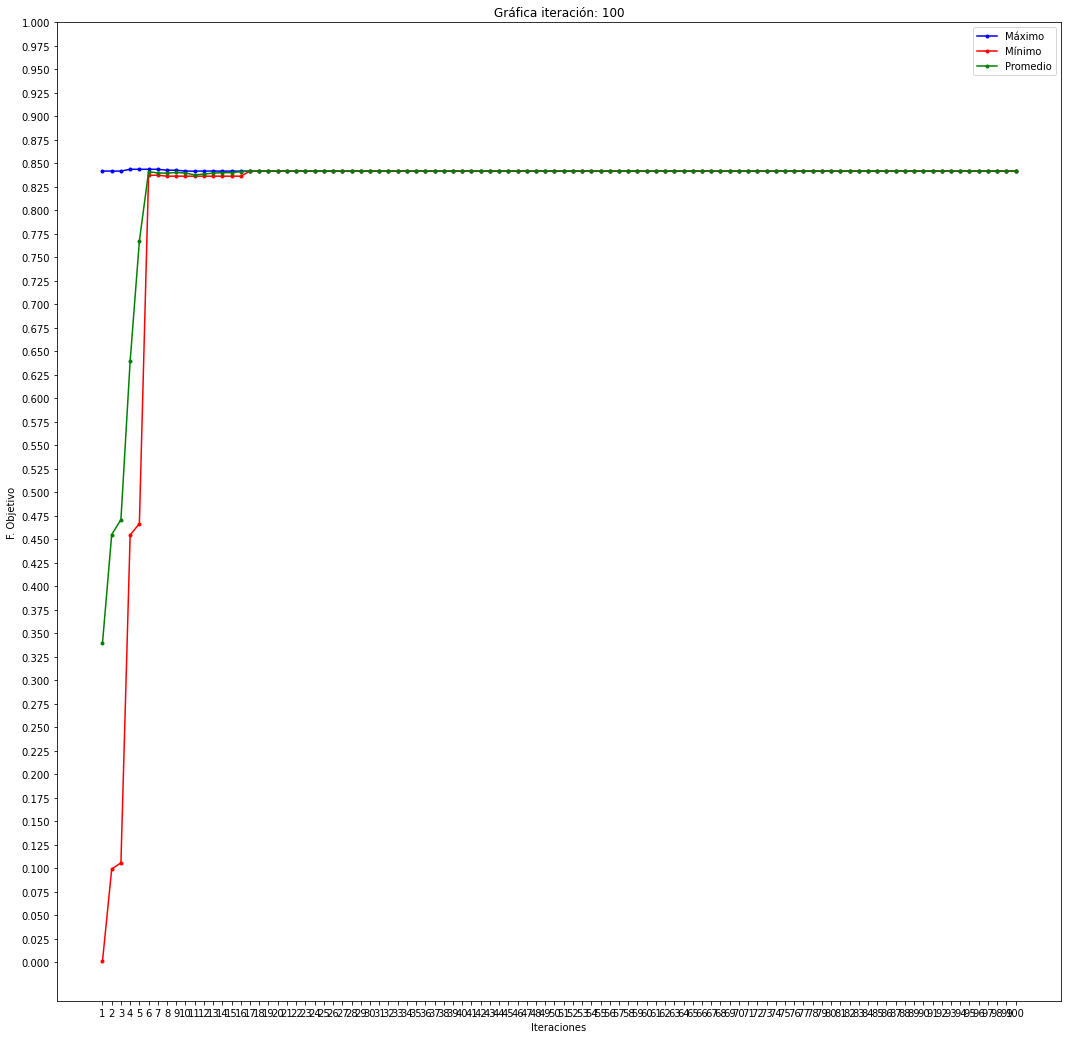

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111101100000001110011010000111,0.9235065137,0.0803228418,0.4150863712
2,111101100000001111000010110111,0.9235111820,0.2550898237,0.6792303169
3,111101100010000001100010000111,0.9243507790,0.5661704129,0.8559221702
4,111101111110000001100010000100,0.9375420767,0.5661704129,0.8514150024
5,111101111110000001100010000111,0.9375420821,0.5661704087,0.8215899055
6,111100001010000000011010000111,0.8834927744,0.6095979941,0.8517109227
7,111100001010000001100101100100,0.8835012289,0.6095979941,0.8248704940
8,111011111110000001100101100100,0.8780023073,0.8779951585,0.8780014645
9,111011111110000001100101100100,0.8780023073,0.8779951585,0.8780001627
10,111011111110000001100101100100,0.8780023073,0.8779951585,0.8780015924


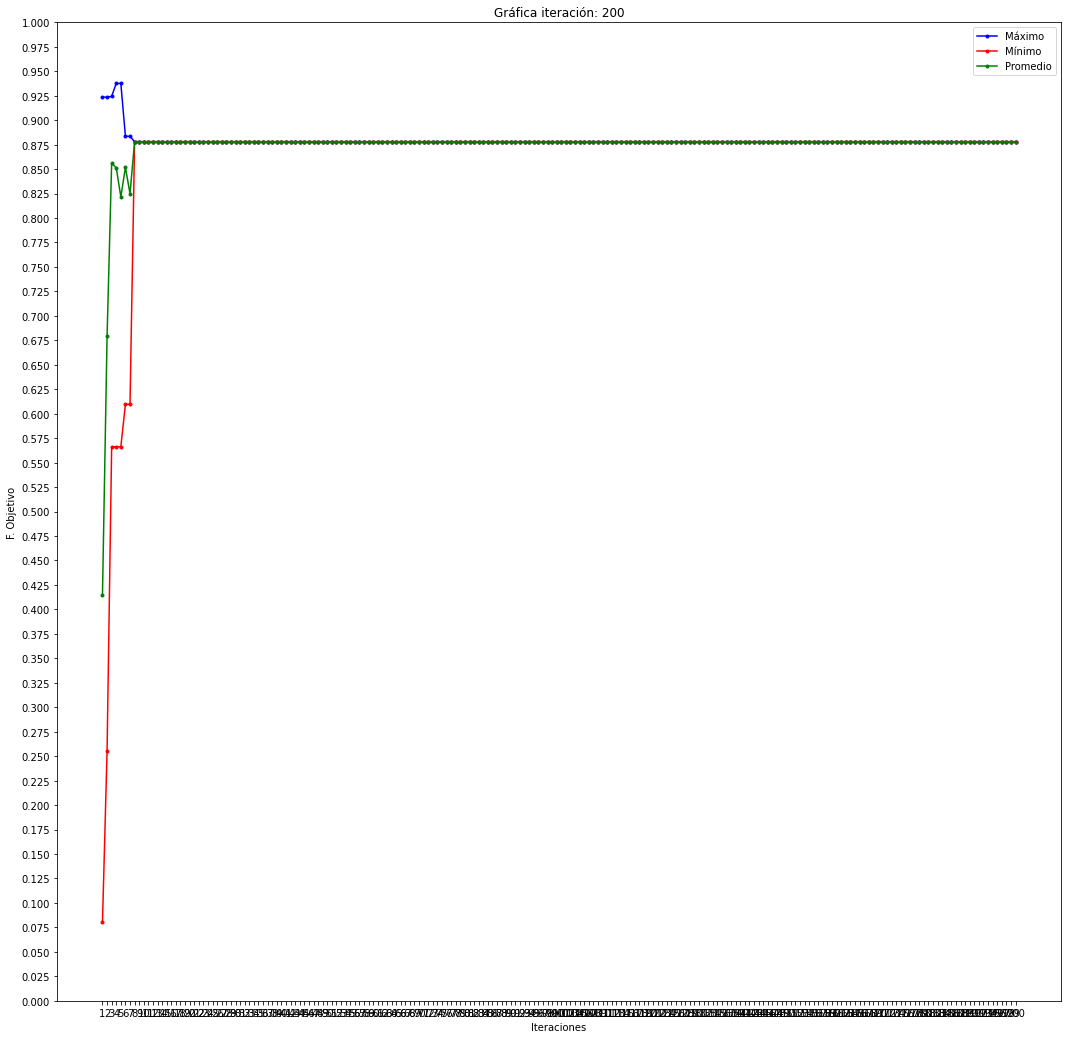

CASO B: Método selección torneo sin mutación


Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,110011100100111100101011101001,0.6494676315,0.0076043130,0.2900472511
2,110011100100111101110101001010,0.6494746942,0.1538322263,0.5650340079
3,110011100100111101110101001011,0.6494746957,0.6182025458,0.6432216006
4,110011100100111101111101111011,0.6494755363,0.6182017256,0.6463474821
5,110011100100111101111101111011,0.6494755363,0.6494746942,0.6494749477
6,110011100100111101111101111011,0.6494755363,0.6494746957,0.6494753682
7,110011100100111101111101111011,0.6494755363,0.6494755363,0.6494755363
8,110011100100111101111101111011,0.6494755363,0.6494755363,0.6494755363
9,110011100100111101111101111011,0.6494755363,0.6494755363,0.6494755363
10,110011100100111101111101111011,0.6494755363,0.6494755363,0.6494755363


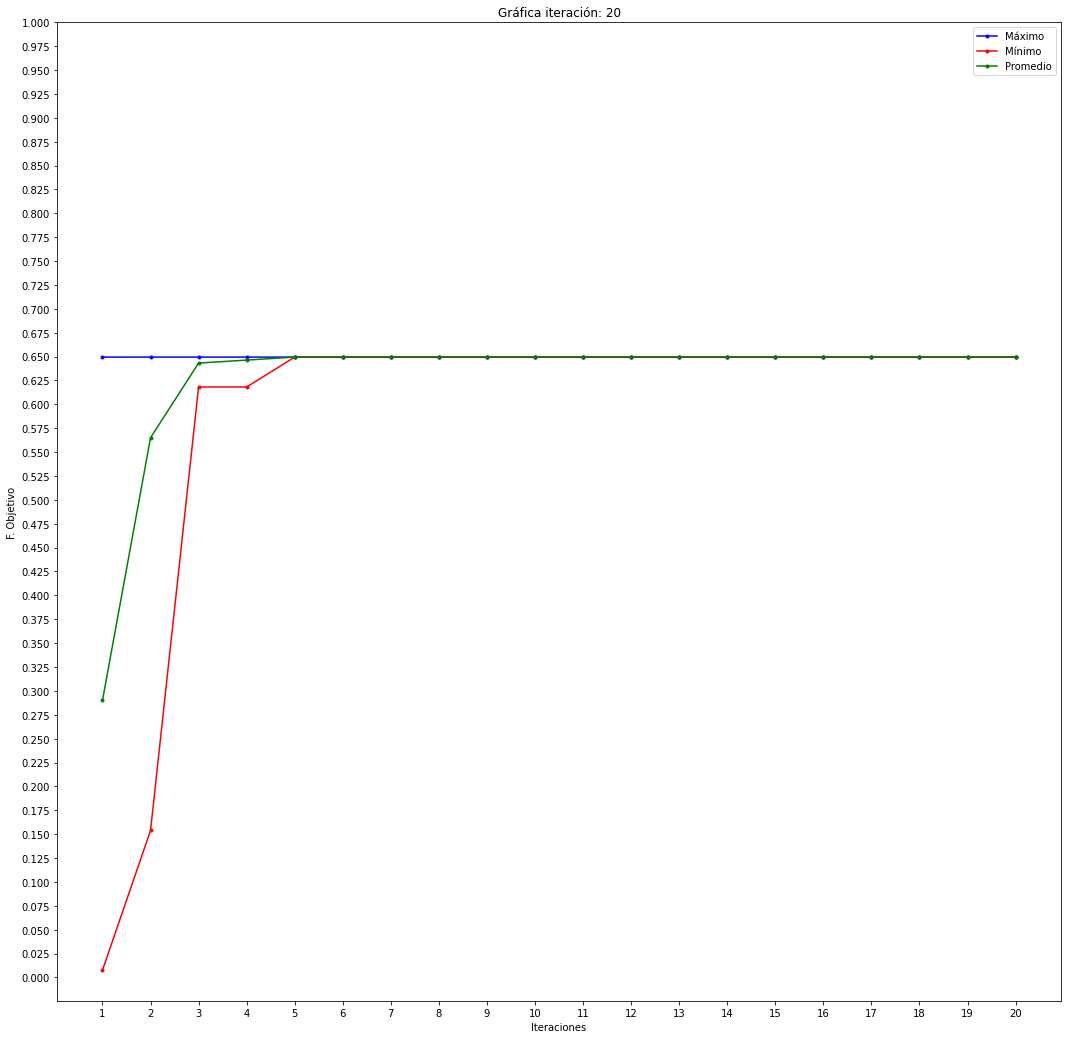

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,101010011011111100001000110000,0.4396634174,0.0023973171,0.1118479317
2,101010011011111100001000110000,0.4396634174,0.0189601558,0.3415226914
3,101010011011111100001000110000,0.4396634174,0.4066560381,0.4330619416
4,101010011011111100001000110000,0.4396634174,0.4072594902,0.4363603239
5,101010011011111100001000110000,0.4396634174,0.4072594902,0.4363603239
6,101010011011111100001000110000,0.4396634174,0.4396634174,0.4396634174
7,101010011011111100001000110000,0.4396634174,0.4396634174,0.4396634174
8,101010011011111100001000110000,0.4396634174,0.4396634174,0.4396634174
9,101010011011111100001000110000,0.4396634174,0.4396634174,0.4396634174
10,101010011011111100001000110000,0.4396634174,0.4396634174,0.4396634174


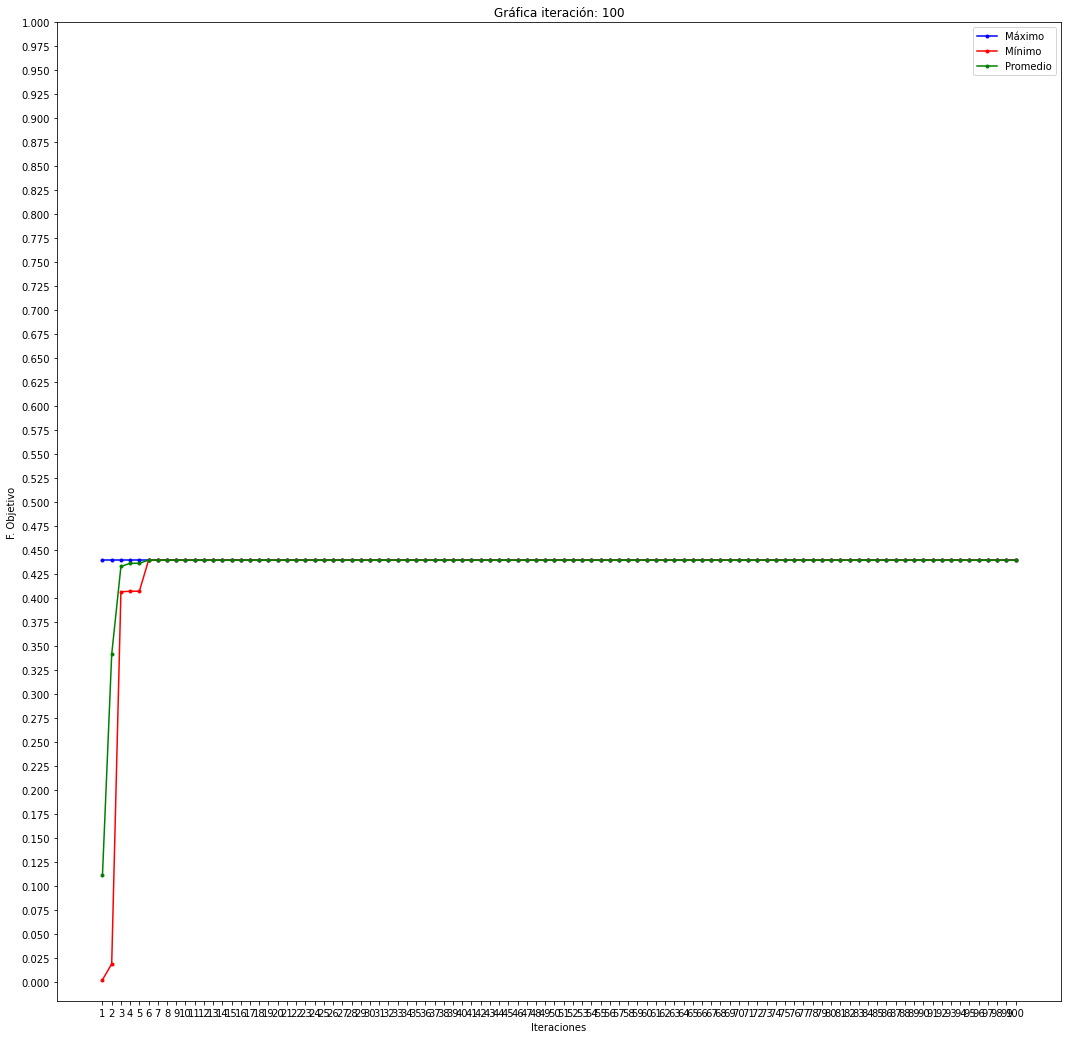

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111111110111110011001010000101,0.9959997796,0.0233659162,0.3248899152
2,111111110111110011001010000101,0.9959997796,0.5981297880,0.8705914054
3,111111110111110011001010000101,0.9959997796,0.9959997796,0.9959997796
4,111111110111110011001010000101,0.9959997796,0.9959997796,0.9959997796
5,111111110111110011001010000101,0.9959997796,0.9959997796,0.9959997796
6,111111110111110011001010000101,0.9959997796,0.9959997796,0.9959997796
7,111111110111110011001010000101,0.9959997796,0.9959997796,0.9959997796
8,111111110111110011001010000101,0.9959997796,0.9959997796,0.9959997796
9,111111110111110011001010000101,0.9959997796,0.9959997796,0.9959997796
10,111111110111110011001010000101,0.9959997796,0.9959997796,0.9959997796


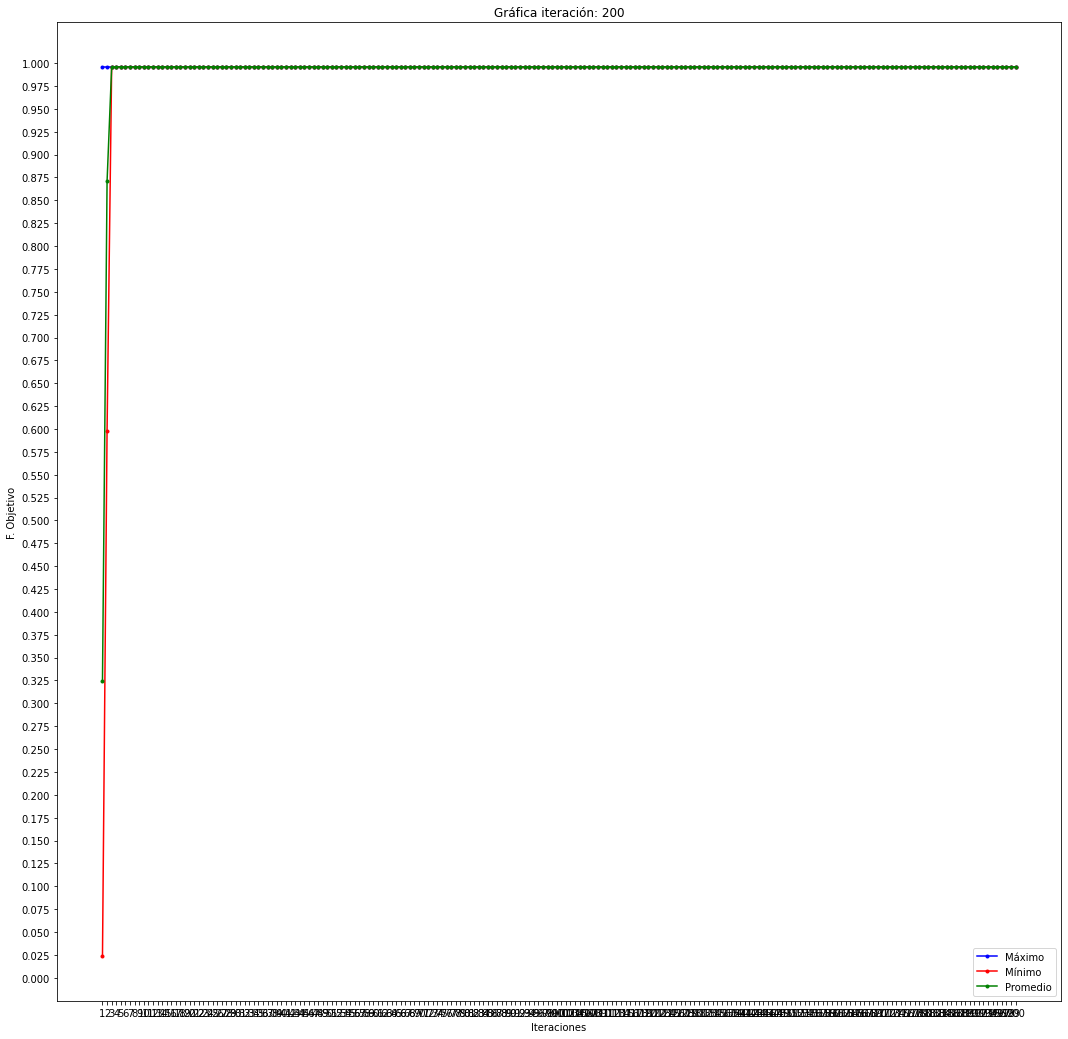

CASO C: Método selección Ruleta con elitismo sin mutacion


Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,110100011000010010001011111011,0.6698256203,0.0000000517,0.3513781747
2,110100011000010010001011111011,0.6698256203,0.3249803029,0.4803521343
3,110100011000010010001011111011,0.6698256203,0.4850468489,0.5704252542
4,110100011000010010001011111011,0.6698256203,0.4850468489,0.6073809985
5,110100011000010010001011111011,0.6698256203,0.4850468489,0.6293643738
6,110100011000010010001011111011,0.6698256203,0.6698255532,0.6698256136
7,110100011000010010001011111011,0.6698256203,0.6698256203,0.6698256203
8,110100011000010010001011111011,0.6698256203,0.6698256203,0.6698256203
9,110100011000010010001011111011,0.6698256203,0.6698256203,0.6698256203
10,110100011000010010001011111011,0.6698256203,0.6698256203,0.6698256203


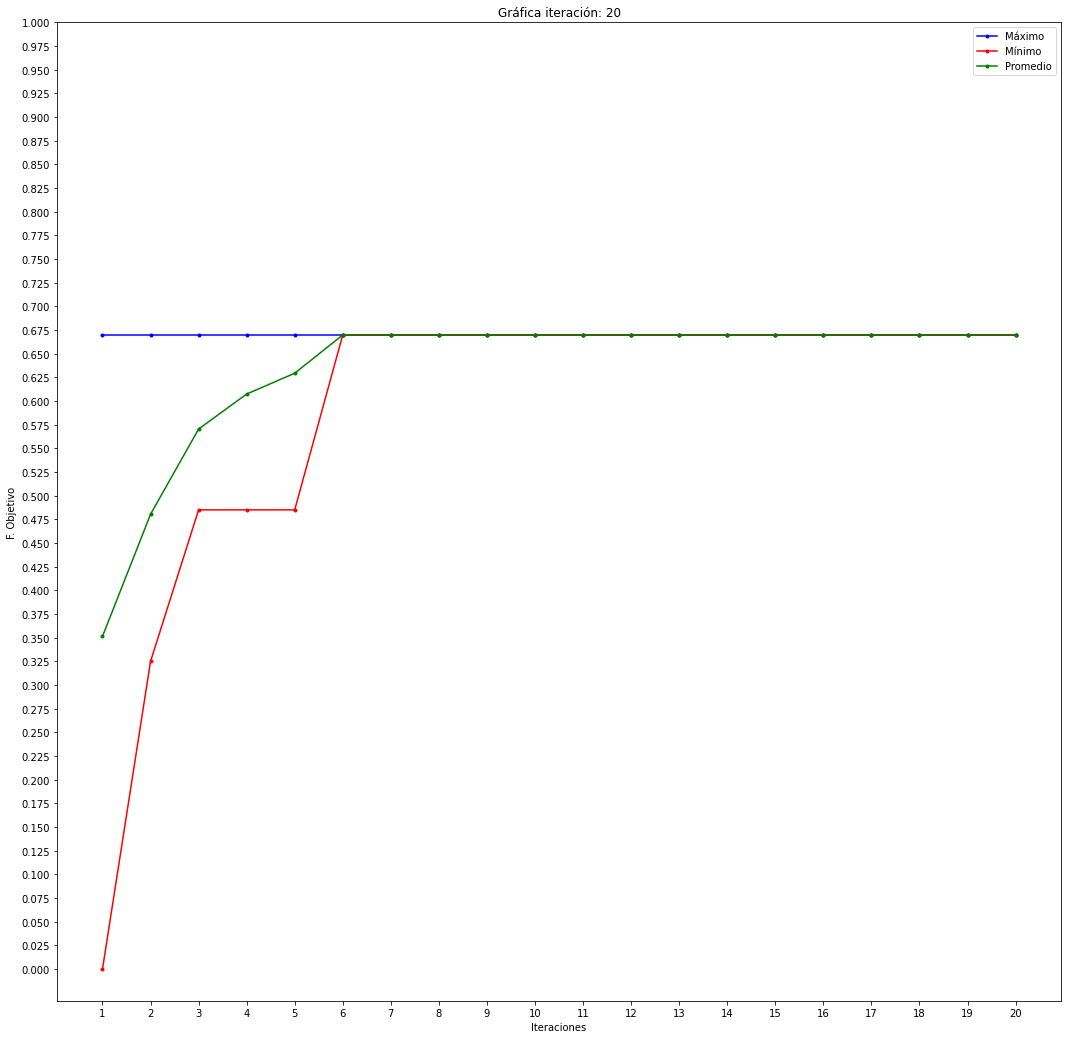

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111111001111111001011011111000,0.9766503357,0.0257097686,0.2755623902
2,111111100110001001000010011111,0.9874135062,0.0904542972,0.7077036540
3,111111101111111001011011111000,0.9921528741,0.9719481847,0.9798829837
4,111111101111111001011011111000,0.9921528741,0.9719481480,0.9788066749
5,111111101111111001011011111000,0.9921528741,0.9766502528,0.9792768891
6,111111101111111001011011111000,0.9921528741,0.9766502528,0.9797508305
7,111111101111111001011011111000,0.9921528741,0.9766503357,0.9813010972
8,111111101111111001011011111000,0.9921528741,0.9766503357,0.9797508433
9,111111101111111001011011111000,0.9921528741,0.9766503357,0.9813010972
10,111111101111111001011011111000,0.9921528741,0.9766503357,0.9828513510


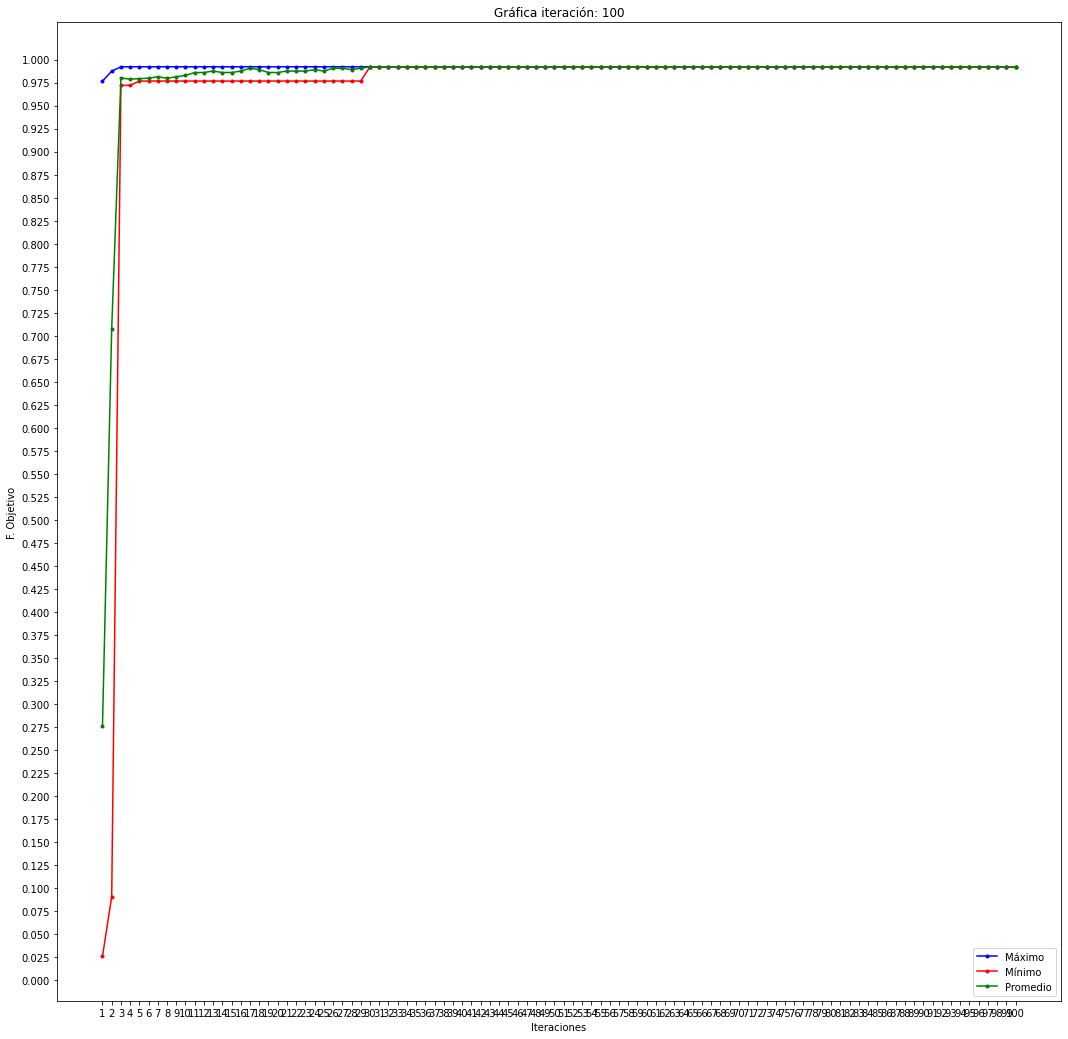

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111111000001001100001001111100,0.9695661670,0.0000477100,0.2427621122
2,111111000001001101101010110000,0.9695775310,0.3649054369,0.6902824300
3,111111000001001101101010110000,0.9695775310,0.3649054492,0.7759715577
4,111111000001001101101010110000,0.9695775310,0.5188284902,0.8364387713
5,111111000001001101101010110000,0.9695775310,0.9695661670,0.9695707508
6,111111000001001101101010110100,0.9695775384,0.9695661597,0.9695718777
7,111111000001001101101010110100,0.9695775384,0.9695661597,0.9695729950
8,111111000001001101101010110100,0.9695775384,0.9695661597,0.9695741328
9,111111000001001101101010110100,0.9695775384,0.9695661597,0.9695737470
10,111111000001001101101010110100,0.9695775384,0.9695661597,0.9695729854


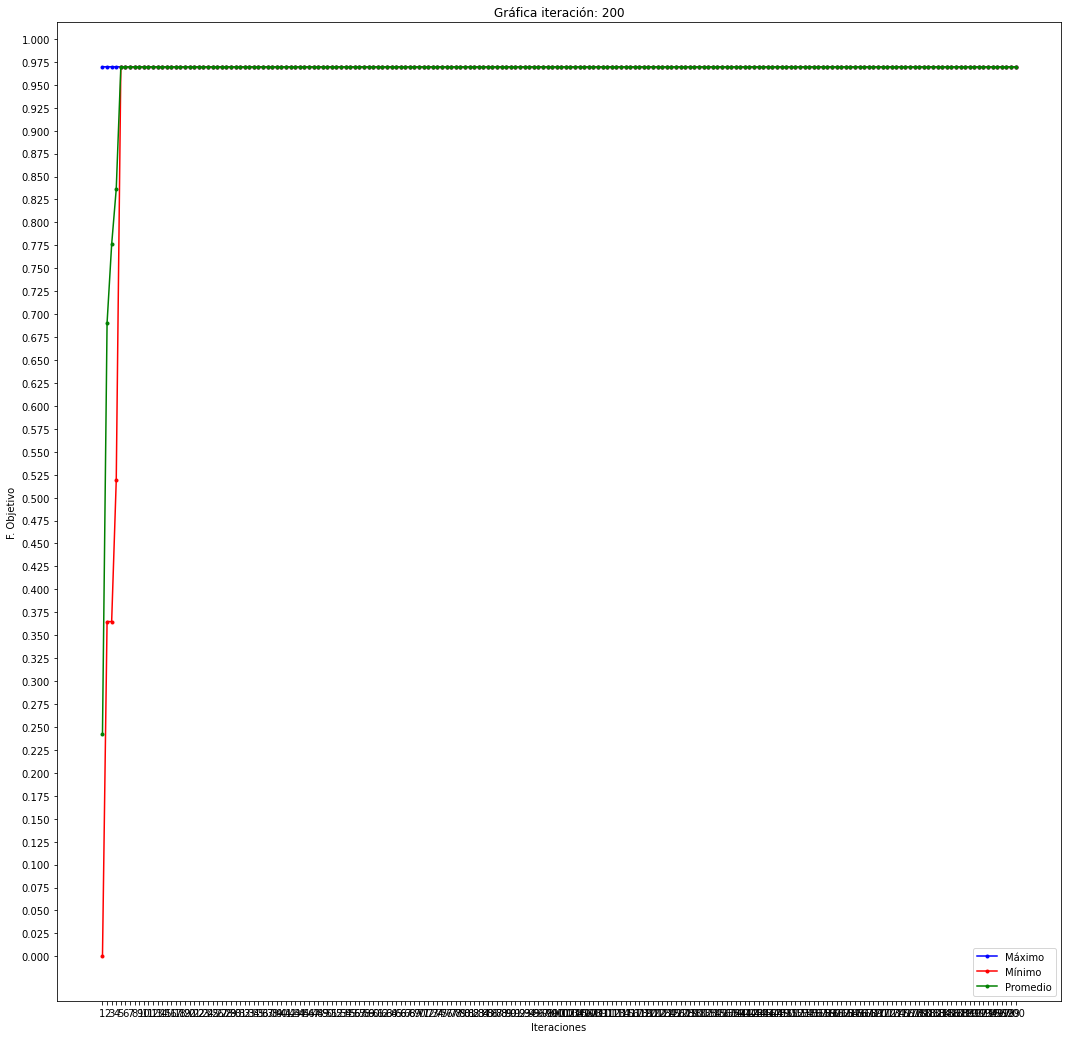

CASO C: Método selección torneo con elitismo sin mutacion


Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111010111111101100000100100011,0.8497133557,0.0187446271,0.4254333500
2,111010111111101100000100100011,0.8497133557,0.4065047987,0.7202884413
3,111010111111101100000100100011,0.8497133557,0.6233323773,0.8042550359
4,111010111111101100000100100011,0.8497133557,0.8497133557,0.8497133557
5,111010111111101100000100100011,0.8497133557,0.8497133557,0.8497133557
6,111010111111101100000100100011,0.8497133557,0.8497133557,0.8497133557
7,111010111111101100000100100011,0.8497133557,0.8497133557,0.8497133557
8,111010111111101100000100100011,0.8497133557,0.8497133557,0.8497133557
9,111010111111101100000100100011,0.8497133557,0.8497133557,0.8497133557
10,111010111111101100000100100011,0.8497133557,0.8497133557,0.8497133557


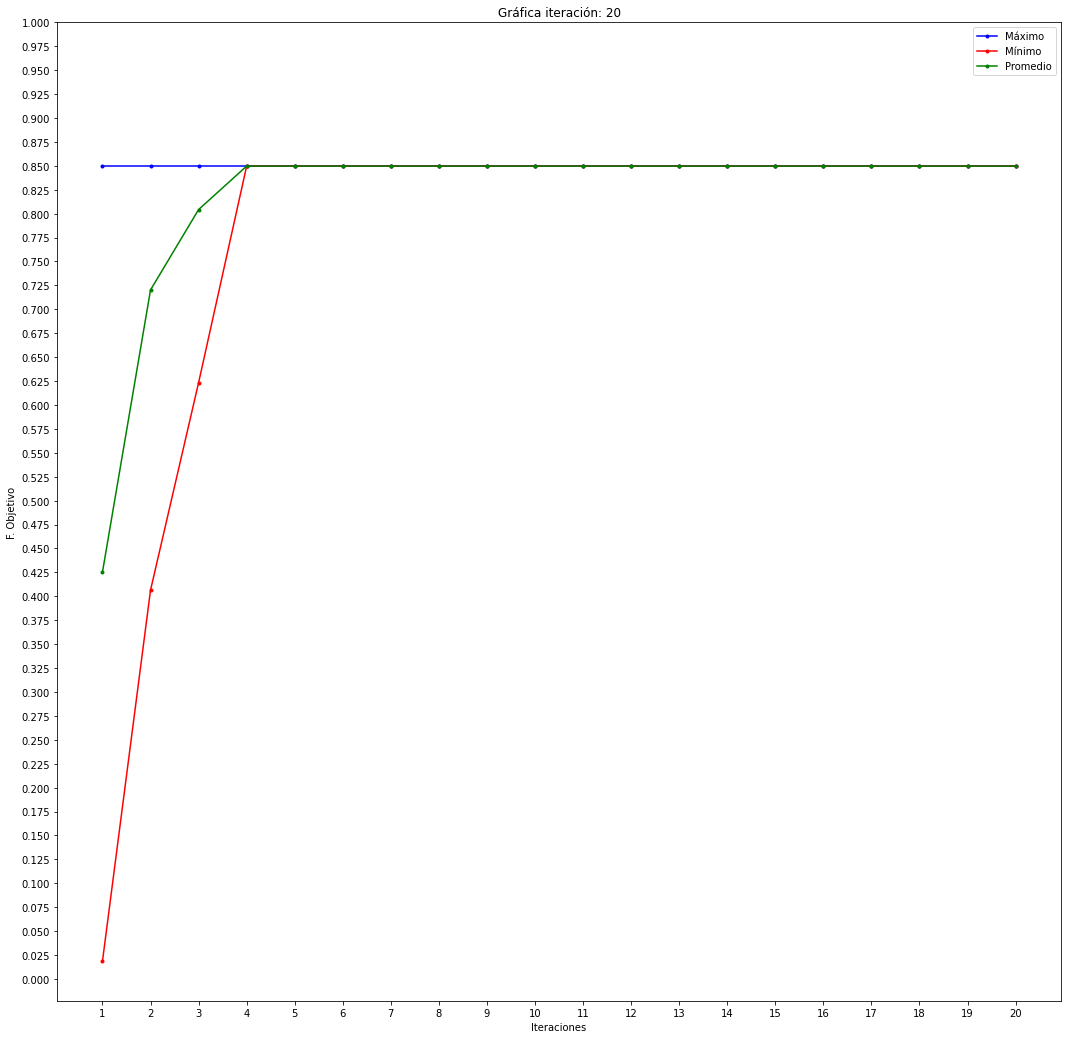

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,100110000000000100111110001101,0.3525615861,0.0004817414,0.1196507400
2,100110000000000100111110001101,0.3525615861,0.2149839667,0.2896640970
3,100110000000000100111110001101,0.3525615861,0.2149839667,0.3388038242
4,100110000000000100111110001101,0.3525615861,0.3525615861,0.3525615861
5,100110000000000100111110001101,0.3525615861,0.3525615861,0.3525615861
6,100110000000000100111110001101,0.3525615861,0.3525615861,0.3525615861
7,100110000000000100111110001101,0.3525615861,0.3525615861,0.3525615861
8,100110000000000100111110001101,0.3525615861,0.3525615861,0.3525615861
9,100110000000000100111110001101,0.3525615861,0.3525615861,0.3525615861
10,100110000000000100111110001101,0.3525615861,0.3525615861,0.3525615861


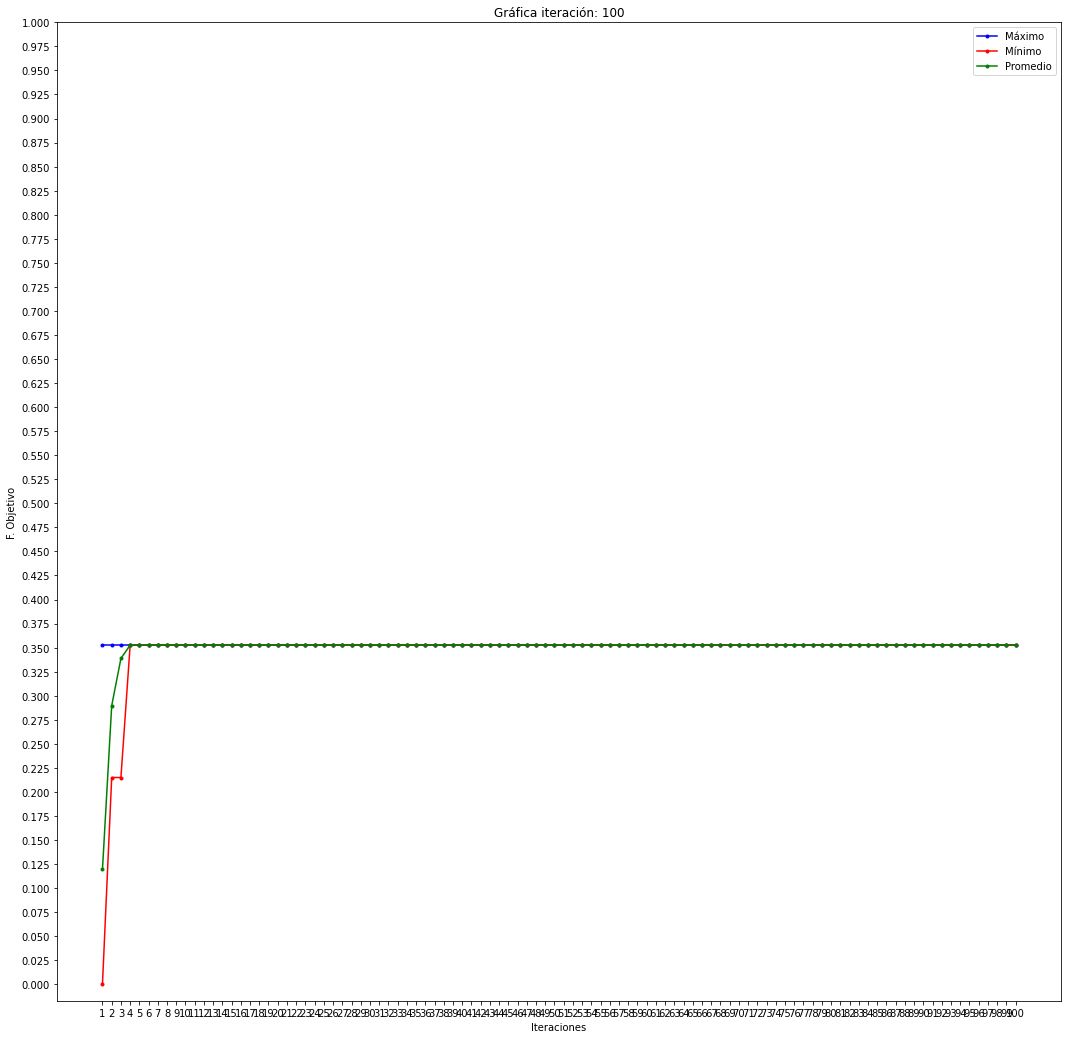

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,110111011110011100001001000001,0.7513536271,0.0065296484,0.3796036477
2,110111100101111000101001001101,0.7545081448,0.2351886121,0.6976889473
3,110111100101111000101001001111,0.7545081480,0.7395354414,0.7514336227
4,110111100101111000101001001111,0.7545081480,0.7545081448,0.7545081471
5,110111100101111000101001001111,0.7545081480,0.7545081448,0.7545081477
6,110111100101111000101001001111,0.7545081480,0.7545081480,0.7545081480
7,110111100101111000101001001111,0.7545081480,0.7545081480,0.7545081480
8,110111100101111000101001001111,0.7545081480,0.7545081480,0.7545081480
9,110111100101111000101001001111,0.7545081480,0.7545081480,0.7545081480
10,110111100101111000101001001111,0.7545081480,0.7545081480,0.7545081480


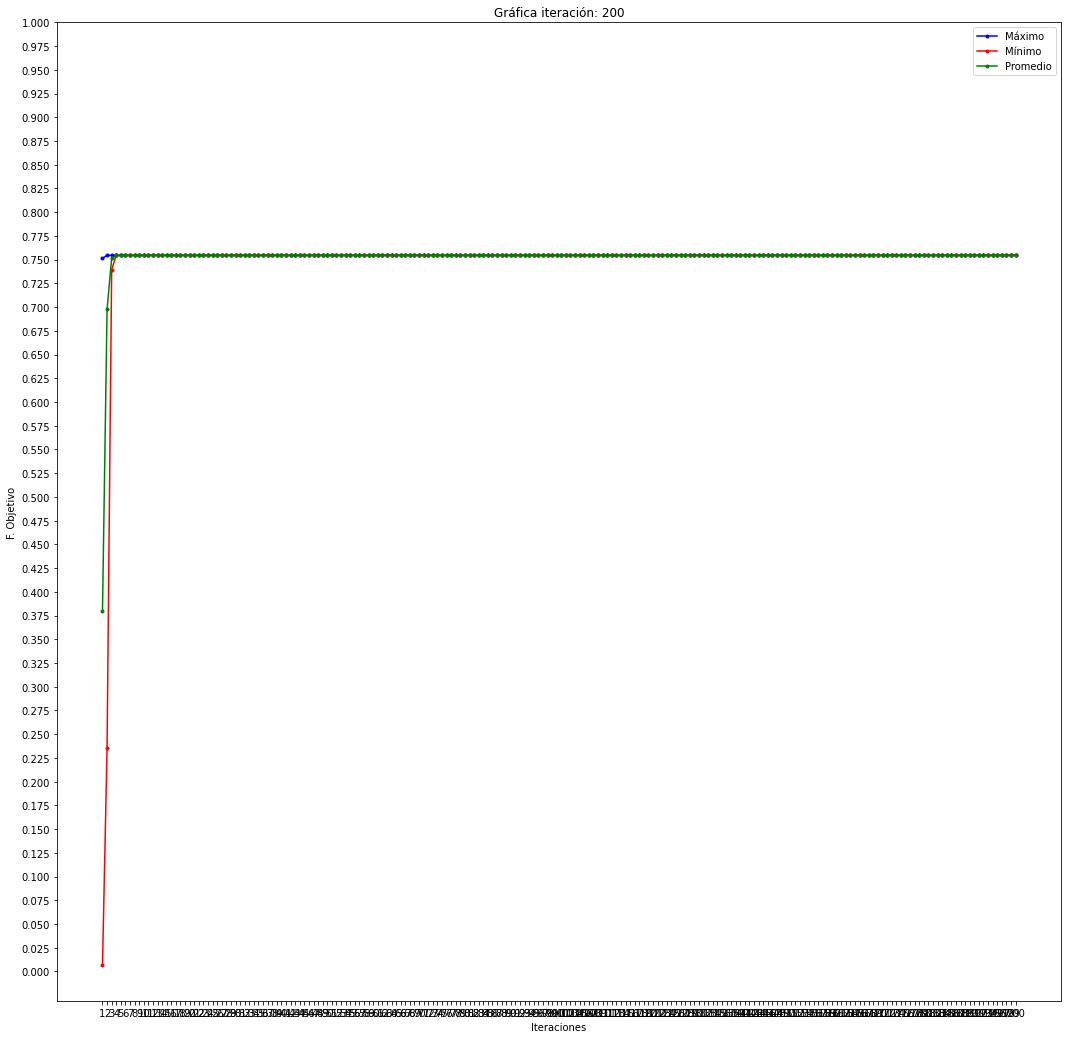

In [23]:
def main(seleccion, ciclos, tieneElitismo = False, mutar = True):
    estadisticas = { "CromosomaMáximo":[],"Máximo":[], "Mínimo":[], "Promedio":[]}
    poblacion_decimal = poblacionInicial()
    poblacion_binarios = convertirPoblacion(poblacion_decimal)
    for i in range(0, ciclos):
        marcoDeDatos = generarDataFrame(poblacion_binarios)
        marcoDeDatos_stats, stats, cromosoma_max = generarEstadisticas(marcoDeDatos)
        estadisticas["CromosomaMáximo"].append(cromosoma_max)
        estadisticas["Máximo"].append(stats['Máximo'][0])
        estadisticas["Mínimo"].append(stats['Mínimo'][0])
        estadisticas["Promedio"].append(stats['Promedio'][0])
        if tieneElitismo:
            elites = elitismo(poblacion_binarios, 2)
            cromosomasPadres = seleccion(poblacion_binarios, 8)
        else:
            cromosomasPadres = seleccion(poblacion_binarios, 10)
        cromosomasHijos = crossover(cromosomasPadres)
        
        if mutar: 
            cromosomasHijosMutados = mutacion(cromosomasHijos)
            if tieneElitismo: 
                poblacion_binarios = cromosomasHijosMutados + elites
            else:
                poblacion_binarios = cromosomasHijosMutados
        else:
            if tieneElitismo: 
                poblacion_binarios = cromosomasHijos + elites
            else:
                poblacion_binarios = cromosomasHijos

        if ( i == ciclos-1 ):
        #if ( (i==(ITERACIONES_IMPRIMIBLES[0] - 1)) or (i==(ITERACIONES_IMPRIMIBLES[1] - 1)) or (i == (ITERACIONES_IMPRIMIBLES[2] - 1)) ): # 20, 100, 200. le resto 1 xq empieza en 0.
            marcoDeDatos = generarDataFrame(poblacion_binarios)
            marcoDeDatos_stats, stats, cromosoma_max = generarEstadisticas(marcoDeDatos)
            tabla = hacerTabla(i+1, estadisticas["CromosomaMáximo"], estadisticas["Máximo"], estadisticas["Mínimo"], estadisticas["Promedio"])
            tabla = tabla.style.hide(axis='index')
            tabla = tabla.format(precision=10)
            display(tabla)

            hacerGrafico(estadisticas, i+1)


debeMutar = True
conElitismo = True 

casos = { 
    "CASO A: Método selección ruleta": ruleta, 
    "CASO B: Método selección torneo": torneo, 
    "CASO C: Método selección Ruleta con elitismo": (ruleta, conElitismo, debeMutar), 
    "CASO C: Método selección torneo con elitismo": (torneo, conElitismo,debeMutar),

    
    "CASO A: Método selección ruleta sin mutacion": (ruleta, not conElitismo,not debeMutar), 
    "CASO B: Método selección torneo sin mutación": (torneo, not conElitismo,not debeMutar), 
    "CASO C: Método selección Ruleta con elitismo sin mutacion": (ruleta, conElitismo,not debeMutar), 
    "CASO C: Método selección torneo con elitismo sin mutacion": (torneo, conElitismo,not debeMutar) 
}  
 
 
for key, value in casos.items(): 
    print(key) 
    tipo_seleccion,conElitismo, conMutacion = (value[0],value[1],value[2]) if type(value) == tuple else (value,False,True) 
    for ciclo in ITERACIONES_IMPRIMIBLES: 
        main(tipo_seleccion, ciclo,conElitismo,conMutacion)



# print("CASO A: Método selección ruleta")
# main(ruleta)
# print("CASO B: Método selección torneo")
# main(torneo)
# print("CASO C: Método selección Ruleta con elitismo")
# main(ruleta, tieneElitismo = True)
# print("CASO C: Método selección torneo con elitismo")
# main(torneo, tieneElitismo = True)

# # Sin mutacion (Se ve como se estanca la función en maximos locales)
# print("-----------------Sin mutación-----------------")
# print("CASO A: Método selección ruleta sin mutación")
# main(ruleta, mutar = False)
# print("CASO B: Método selección torneo sin mutación")
# main(torneo, mutar = False)
# print("CASO C: Método selección Ruleta con elitismo sin mutación")
# main(ruleta, tieneElitismo = True, mutar = False)
# print("CASO C: Método selección torneo con elitismo sin mutación")
# main(torneo, tieneElitismo = True, mutar = False)